In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import qutip as qt
import scipy as sc
import pickle
mpl.rcParams.update({'font.size':22})

# Progress bar yay
from ipywidgets import FloatProgress

# Physical Constants
phi0 = 2.067833831e-15
hbar = 1.054571800e-34
e = 1.6021766208e-19

## Tunable CSFQ with negligible inductance

The tunable capacitively shunted flux qubit (CSFQ) is a four Josephson junction flux qubit where two junction with areas smaller by a factor $\alpha$ form a DC-SQUID. The Hamiltonian for this system can be expressed in the charge basis as

$$\hat{H} = \frac{1}{2}E_\mathrm{C} \hat{n}^2 -2E_\mathrm{J}\cos\left(\hat{\phi}\right) -\alpha E_\mathrm{J}\cos\left(\frac{\phi_x}{2}\right)\cos\left(2\hat{\phi} + \phi_z\right)$$

where $E_\mathrm{C}$ and $E_\mathrm{J}$ are the charging and Josephson energies respectively and $\phi_x$ and $\phi_z$ are the external phases applied to the X and Z loops of the CSFQ respectively. $\hat{n}$ is Cooper pair number operator and $\hat{\phi}$ is the phase operator.

In the charge basis the operators can be expressed as

$$\hat{n} = \hat{a}\hat{a}^\dagger$$

where $\hat{a}$ is the creation operator.

The phase operators can be expressed as

$$\cos\left(\hat{\phi}+\phi_e\right) = \frac{1}{2}\left( e^{j\phi_e} \hat{D} + e^{-j\phi_e} \hat{D}^\dagger \right)$$

where $\hat{D}$ is the charge raising operator which has the property

$$\hat{D} |n\rangle = |n+1\rangle$$

The last term in the Hamiltonian is written as

$$\cos\left(2\hat{\phi}+\phi_e\right) = \frac{1}{2}\left( e^{j\phi_e} {\hat{D}}^2 + e^{-j\phi_e} {\hat{D}^{\dagger 2}} \right)$$

in terms of the defined operators. The charge raising operator can be defined in qutip by building the operator with the charge (Fock) states:

$$\hat{D} = \sum_{n=0}^{N-1}|n\rangle\langle n+1|$$

With these definitions it is possible to diagonalise the Hamiltonian and find the energy eigenvalues and eigenstates.

#### Hamiltonian Definition:

In [3]:
# CSFQ parameters
Jc = 3 # uA/um^2
Ca = 60 # fF/um^2
Ajj = 0.2*0.2 # um^2, 2 JJs worth
Csh = 105e-15 # Shunting capacitor
alpha = 1.0

# Save object to binary file
def saveBin(obj,fname):
    fd = open(fname,"wb")
    pickle.dump(obj,fd)
    fd.close()

# Load binary file
def loadBin(fname):
    fd = open(fname,"rb")
    obj = pickle.load(fd)
    fd.close()
    return obj

#
# Plot map function
#
# zdata is a list of lists:
#
#  If xdata and ydata have the same dimensions, ensure the zdata is properly formatted:
#  --
#
#  zdata = 
#  [ [z1,z2...], [z1,z2...] ]
#    |xvals...   |xvals...
#    yval1       yval2
#
#  ie:
#
#  zdata[yval_index][xval_index]
#
#  If xdata and ydata have different dimensions, the correct orientation of zdata is automagically determined.
#  --
#
#  figsize: x,y tuple in pixels (width,height)
#
def plot_map(xdata,xlabel,ydata,ylabel,zdata,zlabel,cmap='gray',markers=None,polys=None):

    # Format data
    Xpts,Ypts,Zpts = np.array(xdata),np.array(ydata),np.array(zdata)

    # Data properties
    nx = Xpts.shape[0]
    ny = Ypts.shape[0]
    nz1 = Zpts.shape[0]
    nz2 = Zpts.shape[1]

    # Inverted case
    if nx == nz1 and ny == nz2 and not nx == ny:
        Zpts = Zpts.T
    #Zpts = Zpts.T

    # Determine xstep and ystep (assumes linear increment)
    xs = np.abs(Xpts[0]-Xpts[1])
    ys = np.abs(Ypts[0]-Ypts[1])

    # Add the boundary point
    Xpts, Ypts = np.append(Xpts,Xpts[-1]+xs), np.append(Ypts,Ypts[-1]+ys)

    # Generate mesh
    X,Y = np.meshgrid(Xpts,Ypts)

    # Centre Z color quad coordinates
    X,Y = X-xs/2, Y-ys/2

    # Determine bounds for colorbar
    zmin, zmax = Zpts.min(), Zpts.max()

    # Get figure and axis object
    fig = plt.figure(figsize=(15,8))
    ax1 = plt.subplot(111)

    # Finish plot
    #fig.suptitle(title,size=titlefontsize)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_xscale("linear")
    ax1.set_yscale("linear")
    mesh = ax1.pcolormesh(X,Y,Zpts,cmap=cmap,vmin=zmin, vmax=zmax)
    cbar = fig.colorbar(mesh)
    cbar.set_label(zlabel,rotation=-90,labelpad=20)
    
    # Add markers
    if markers is not None:
        xpts,ypts,style = markers
        ax1.plot(xpts,ypts,style)
        for i in range(len(xpts)):
            ax1.annotate("%i"%i,(xpts[i],ypts[i]))
    
    # Add polygons
    if polys is not None:
        for arr in polys:
            poly = mpl.patches.Polygon(arr,alpha=0.4)
            ax1.add_patch(poly)
    
    fig.tight_layout()

#
# CSFQ Class
#
class CSFQ_Qubit:
    
    # Required parameters (keys)
    params_required = ["Jc",# Critical current density (FAB)
                       "Ca",# Capacitance density (FAB)
                       "Ajj",# Large junction area
                       "Csh",# Shunt capacitance
                       "alpha",# Ratio of small to large JJ area
                       "trunc"# Operator truncation
                      ]
    
    # Optional parameters (keys)
    params_optional = ["Cs", # Stray capacitance
                       "Xasy" # X loop JJ asymmetry
                      ]
    
    # External parameters
    params_ext = ["phi_x",
                  "phi_z"
                 ]
    
    # Energy units
    units_energy = ["J", # Joules
                    "GHz" # GHz
                   ]
    
    # Parameter sweep output options
    sweep_output = ["E", # Eigenenergies only
                    "EandS" # Eigenenergies and states
                   ]
    
    # Initialisation
    def __init__(self,csfq_params):
        
        # Update required parameters
        if csfq_params:
            missing = []
            for key in CSFQ_Qubit.params_required:
                if key not in list(csfq_params.keys()):
                    missing.append(key)
            if missing != []:
                raise Exception("Missing parameters in CSFQ parameter list:\n\t %s" % missing)
        else:
            raise Exception("Empty CSFQ parameter list.")
        self.params = csfq_params
        
        # Update optional parameters
        
        # Construct the operators
        self.op_charge_number()
        self.op_charge_raising()
        self.op_charge_lowering()
    
    # Print CSQF information
    def info(self):
        for k in list(self.params.keys()):
            print ("[%s] = %e" % (k,self.params[k]))
        print ("[Csigma] = %e F" % self.get_Csigma())
        print ("[Ec] = %e GHz" % self.get_Ec())
        print ("[Ej (large)] = %e GHz" % self.get_large_Ej())
        print ("[Ej (small)] = %e GHz" % self.get_small_Ej())
        print ("[Ej/Ec] = %.1f\n" % (self.get_small_Ej()/self.get_Ec()))
    
    # Get total capacitance seen by small junction (F)
    def get_Csigma(self):
        
        # Small junction
        Csmall = self.params["alpha"]*self.params["Ajj"]*self.params["Ca"]*1e-15 + self.params["Csh"]
        
        # Large junctions (in series)
        Clarge = 0.5*self.params["Ajj"]*self.params["Ca"]*1e-15
        
        return Csmall + Clarge
    
    # Get small junction energy (J)
    def get_small_Ej(self,unit="GHz"):
        if unit not in CSFQ_Qubit.units_energy:
            raise Exception("Unrecognized unit of energy.")
        if unit == "J":
            return self.params["alpha"]*self.params["Ajj"]*self.params["Jc"]*phi0/(2*np.pi) * 1e-6
        elif unit == "GHz":
            return self.params["alpha"]*self.params["Ajj"]*self.params["Jc"]*phi0/(4*np.pi**2*hbar) * 1e-15
    
    # Get large junction energy (J)
    def get_large_Ej(self,unit="GHz"):
        if unit not in CSFQ_Qubit.units_energy:
            raise Exception("Unrecognized unit of energy.")
        if unit == "J":
            return self.params["Ajj"]*self.params["Jc"]*phi0/(2*np.pi) * 1e-6
        elif unit == "GHz":
            return self.params["Ajj"]*self.params["Jc"]*phi0/(4*np.pi**2*hbar) * 1e-15
    
    # Get charging energy seen by small junctions
    def get_Ec(self,unit="GHz"):
        if unit not in CSFQ_Qubit.units_energy:
            raise Exception("Unrecognized unit of energy '%s'." % unit)
        if unit == "J":
            return 2*e**2/self.get_Csigma()
        elif unit == "GHz":
            return 2*e**2/(self.get_Csigma()*2*np.pi*hbar) * 1e-9
    
    # Create charge operator
    def op_charge_number(self):
        if hasattr(self,"op_n"):
            return self.op_n
        else:
            self.op_n = qt.num(self.params["trunc"],-(self.params["trunc"] - 1)/2)
    
    # Create charge raising operator
    def op_charge_raising(self):
        if hasattr(self,"op_Dp"):
            return self.op_Dp
        else:
            self.op_Dp = qt.qeye(self.params["trunc"]) - qt.qeye(self.params["trunc"])
            for i in range(self.params["trunc"]-1):
                self.op_Dp += qt.basis(self.params["trunc"],i)*qt.basis(self.params["trunc"],i+1).dag()
    
    # Create charge lowering operator
    def op_charge_lowering(self):
        if hasattr(self,"op_Dm"):
            return self.op_Dm
        else:
            if not hasattr(self,"op_Dp"):
                raise Exception("Define the raising operator first.")
            else:
                self.op_Dm = self.op_Dp.dag()
    
    # Create phase operator
    def op_phase(self):
        
        # Still need to find a way to express natively in qutip
        pass
    
    # Get Hamiltonian operator
    def op_hamiltonian(self,phi_x,phi_z,ret=False):
        
        # Always update
        self.op_H = 0.5*self.get_Ec()*self.op_n**2 - \
        self.get_large_Ej()*(self.op_Dp+self.op_Dm) + \
        0.5*self.get_small_Ej()*np.cos(phi_x/2)*(np.exp(1j*phi_z)*self.op_Dp**2+np.exp(-1j*phi_z)*self.op_Dm**2)
        if ret:
            return self.op_H
    
    # Get asymmetric Hamiltonian operator
    def op_hamiltonian_asy(self,phi_x,phi_z,ret=False):
        
        # Asymmetry factor and phase
        asy_f = np.sqrt(1 + self.params["Xasy"]**2 * np.tan(phi_x/2)**2)
        asy_p = np.arctan(self.params["Xasy"] * np.tan(phi_x/2))
        
        # Always update
        self.op_H = 0.5*self.get_Ec()*self.op_n**2 - \
        self.get_large_Ej()*(self.op_Dp+self.op_Dm) + \
        asy_f*0.5*self.get_small_Ej()*np.cos(phi_x/2)*(np.exp(1j*(phi_z-asy_p))*self.op_Dp**2+np.exp(-1j*(phi_z-asy_p))*self.op_Dm**2)
        if ret:
            return self.op_H
    
    # External parameter sweep sub function
    def param_sweep_ext(self,param,ext_vars,sweep_var,output="E",ipy_pbar=True):
        
        # Empty the result variables
        self.sweep_var = []
        self.sweep_result = []
        
        # Check if using ipython progress bar
        if ipy_pbar:
            
            # Setup progress bar
            f = FloatProgress(min=0, max=len(sweep_var))
            print("'%s' sweep progress:" % param)
            display(f)
            
            if param == "phi_x":
                if output == "EandS":
                    for phi_x in sweep_var:
                        self.op_hamiltonian(phi_x,ext_vars[0])
                        self.sweep_result.append(self.op_H.eigenstates())
                        f.value+=1
                elif output == "E":
                    for phi_x in sweep_var:
                        self.op_hamiltonian(phi_x,ext_vars[0])
                        E,S = self.op_H.eigenstates()
                        self.sweep_result.append(E)
                        f.value+=1
            if param == "phi_z":
                if output == "EandS":
                    for phi_z in sweep_var:
                        self.op_hamiltonian(ext_vars[0],phi_z)
                        self.sweep_result.append(self.op_H.eigenstates())
                        f.value+=1
                elif output == "E":
                    for phi_z in sweep_var:
                        self.op_hamiltonian(ext_vars[0],phi_z)
                        E,S = self.op_H.eigenstates()
                        self.sweep_result.append(E)
                        f.value+=1
        else:
            if param == "phi_x":
                if output == "EandS":
                    for phi_x in sweep_var:
                        self.op_hamiltonian(phi_x,ext_vars[0])
                        self.sweep_result.append(self.op_H.eigenstates())
                elif output == "E":
                    for phi_x in sweep_var:
                        self.op_hamiltonian(phi_x,ext_vars[0])
                        E,S = self.op_H.eigenstates()
                        self.sweep_result.append(E)
            if param == "phi_z":
                if output == "EandS":
                    for phi_z in sweep_var:
                        self.op_hamiltonian(ext_vars[0],phi_z)
                        self.sweep_result.append(self.op_H.eigenstates())
                elif output == "E":
                    for phi_z in sweep_var:
                        self.op_hamiltonian(ext_vars[0],phi_z)
                        E,S = self.op_H.eigenstates()
                        self.sweep_result.append(E)
        
        # Return result in suitable format
        self.sweep_result = np.array(self.sweep_result).T
        self.sweep_var = sweep_var
        return (sweep_var,self.sweep_result)
    
    # Static linear parameter sweep
    def param_sweep_lin(self,param,ext_vars,start,end,num,overwrite=False,output="E",ipy_pbar=True):
        
        # 
        if output not in CSFQ_Qubit.sweep_output:
            raise Exception("Unrecognised sweep output option '%s'." % output)
        
        if param not in CSFQ_Qubit.params_ext and param not in CSFQ_Qubit.params_required and param not in CSFQ_Qubit.params_optional:
            raise Exception("Unrecognised sweep parameter '%s'." % param)
        
        if not overwrite:
            if hasattr(self,"sweep_result"):
                raise Exception("Not overwritting existing sweep_result.")
        
        # Create the parameter sweep array
        sweep_var = np.linspace(start,end,num)
        
        # Perform sweep on desired external parameter
        if param in CSFQ_Qubit.params_ext:
            return self.param_sweep_ext(param,ext_vars,sweep_var,output=output,ipy_pbar=ipy_pbar)
        
        # Perform sweep on desired internal parameter
        # TODO
        elif param in CSFQ_Qubit.params_required:
            pass
        
    # Perturbative mapping to Pauli coefficients
    def get_AB_perturbative(self,phi_x,phi_z):
        
        # Get the first two state vectors from Hamiltonian diagonalised at phi_z = 0
        self.op_hamiltonian(phi_x,0.0)
        Ei,states = self.op_H.eigenstates()
        gs = states[0]
        es = states[1]

        # Projection
        ex = (gs.dag()*(self.op_Dm**2 - self.op_Dp**2)*es)[0][0]
        Ip = 2*np.pi/phi0*self.get_small_Ej(unit="J")*np.abs(np.cos(phi_x/2)*ex)[0]
        #print (Ip)
        # Coefficients
        A = 0.5*(Ei[1] - Ei[0])
        B = phi0*Ip*phi_z/(4*np.pi**2*hbar)*1e-9
        return (A,B)
    
    # Mapping to 2-level system
    def get_AB(self,phi_x,phi_z,method="pert"):
        if method == "pert":
            return self.get_AB_perturbative(phi_x,phi_z)
    
    # Find optimal flux values for start and end of schedules
    def optimise_flux_schedules(self,Amax,Bmax,method="pert",xmin=0.0):
        
        # Root finding callbacks
        def startx(x):
            A,B = self.get_AB(x[0],0,method=method)
            return [A-Amax]
        def endz(z):
            A,B = self.get_AB(xmin,z[0],method=method)
            return [B-Bmax]
        
        # Get A flux
        retA = sc.optimize.root(startx,[0.9*np.pi])
        if not retA.success:
            raise Exception("Not converged: %s" % retA.message)
        
        # Get A flux
        retB = sc.optimize.root(endz,[0.005])
        if not retB.success:
            raise Exception("Not converged: %s" % retB.message)
        
        return (retA.x[0],retB.x[0])



In [4]:
# MIT early CSFQs

# Create qubits
qubit1_params = {"Ajj":0.1,"alpha":0.97,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

qubit2_params = {"Ajj":0.1,"alpha":0.4,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80}
qubit2 = CSFQ_Qubit(qubit2_params)
qubit2.info()

# Z Parameter sweep
phi_x = 0.0
z_pts1,Ez_pts1 = qubit1.param_sweep_lin("phi_z",[phi_x],-0.2*np.pi,0.2*np.pi,201)
z_pts2,Ez_pts2 = qubit2.param_sweep_lin("phi_z",[phi_x],-0.2*np.pi,0.2*np.pi,201)

# X Parameter sweep
phi_z = 0.0
x_pts1,Ex_pts1 = qubit1.param_sweep_lin("phi_x",[phi_z],-2*np.pi,2*np.pi,201,True)
x_pts2,Ex_pts2 = qubit2.param_sweep_lin("phi_x",[phi_z],-2*np.pi,2*np.pi,201,True)


[Ajj] = 1.000000e-01
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.288200e-13 F
[Ec] = 3.386108e-01 GHz
[Ej (large)] = 1.490051e+02 GHz
[Ej (small)] = 1.445349e+02 GHz
[Ej/Ec] = 426.8

[Ajj] = 1.000000e-01
[alpha] = 4.000000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.254000e-13 F
[Ec] = 3.437485e-01 GHz
[Ej (large)] = 1.490051e+02 GHz
[Ej (small)] = 5.960202e+01 GHz
[Ej/Ec] = 173.4

'phi_z' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_z' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_x' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_x' sweep progress:


FloatProgress(value=0.0, max=201.0)

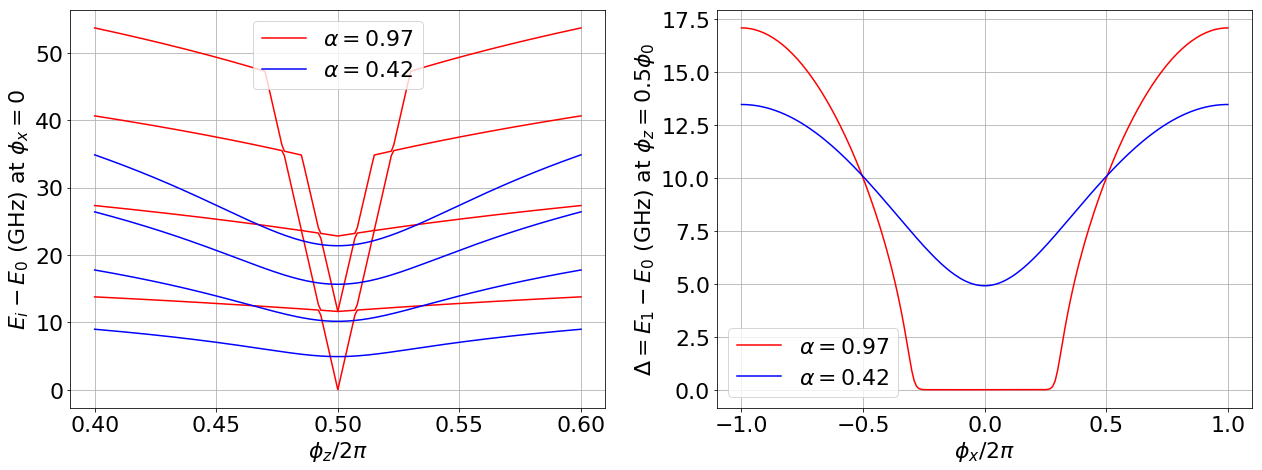

In [5]:
# Plot CSFQ energy levels
fig = plt.figure(figsize=(18,7))

ax1 = plt.subplot(121)
for i in range(4):
    ax1.plot(z_pts1/(np.pi*2)+0.5, Ez_pts1[i+1]-Ez_pts1[0],"r-",label="$\\alpha=0.97$")
    ax1.plot(z_pts2/(np.pi*2)+0.5, Ez_pts2[i+1]-Ez_pts2[0],"b-",label="$\\alpha=0.42$")
ax1.set_xlabel('$\phi_z/2\pi$')
ax1.set_ylabel('$E_i-E_0$ (GHz) at $\phi_x = 0$')
h1,l1 = ax1.get_legend_handles_labels()
ax1.grid()
ax1.legend(h1[:2],l1[:2])

ax2 = plt.subplot(122)
ax2.plot(x_pts1/(np.pi*2), Ex_pts1[1]-Ex_pts1[0],"r-",label="$\\alpha=0.97$")
ax2.plot(x_pts2/(np.pi*2), Ex_pts2[1]-Ex_pts2[0],"b-",label="$\\alpha=0.42$")
ax2.set_xlabel('$\phi_x/2\pi$')
ax2.set_ylabel('$\Delta = E_1-E_0$ (GHz) at $\phi_z = 0.5\phi_0$')
ax2.grid()
ax2.legend()

fig.tight_layout()

In [9]:
# 2D param sweep
phix = np.linspace(-2*np.pi,2*np.pi,101)
phiz = np.linspace(-2*np.pi,2*np.pi,201)

# Qubit def
qubit1_params = {"Ajj":0.31*0.2,"alpha":0.97,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80,"Xasy":0.1}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

# Progress
f = FloatProgress(min=0, max=(len(phix)*len(phiz)))
print("XZ sweep progress:")
display(f)

# Do the sweep
Z1 = np.zeros([len(phix),len(phiz)])
Z2 = np.zeros([len(phix),len(phiz)])
i = 0
j = 0
for x in phix:
    j = 0
    for z in phiz:
        Ei,psii = qubit1.op_hamiltonian(x,z,ret=True).eigenstates()
        Z1[i,j] = Ei[1]-Ei[0]
        
        Ei,psii = qubit1.op_hamiltonian_asy(x,z,ret=True).eigenstates()
        Z2[i,j] = Ei[1]-Ei[0]
        
        f.value += 1
        j+=1
    i+=1

[Ajj] = 6.200000e-02
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Xasy] = 1.000000e-01
[Csigma] = 2.254684e-13 F
[Ec] = 3.436442e-01 GHz
[Ej (large)] = 9.238313e+01 GHz
[Ej (small)] = 8.961164e+01 GHz
[Ej/Ec] = 260.8

XZ sweep progress:


FloatProgress(value=0.0, max=20301.0)

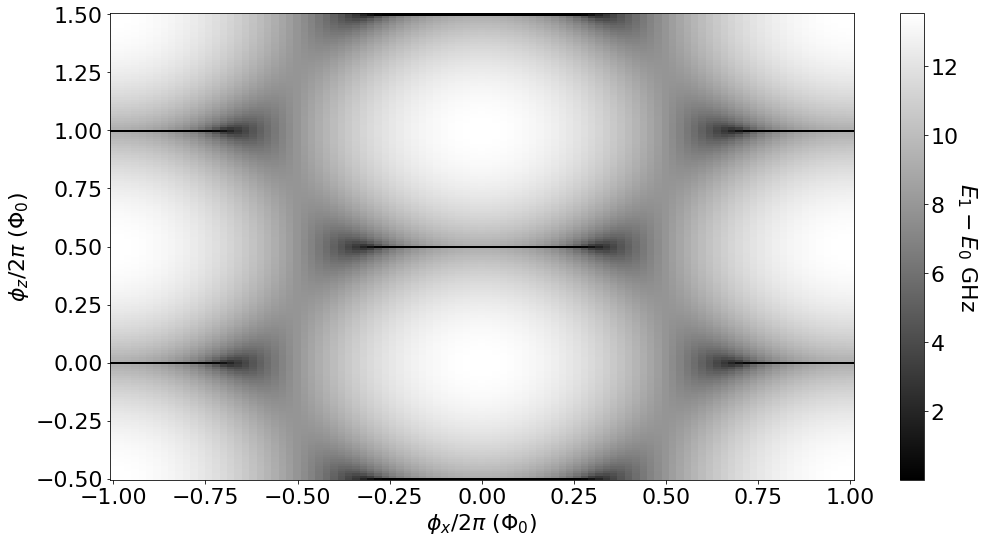

In [21]:
# Plot map
plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",Z1,"$E_1 - E_0$ GHz")

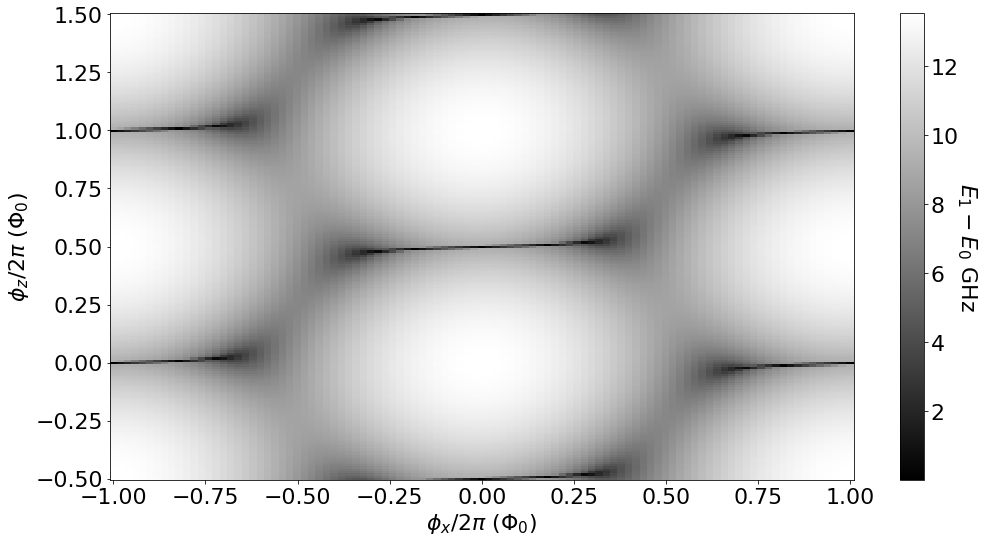

In [10]:
# Plot map
plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",Z2,"$E_1 - E_0$ GHz")

## Qubit-Resonator Interaction

First we will use the Jaynes-Cummings model of a two-level system coupled to a oscillator, and track the change in resonant frequency against varying the energy terms in the two-level system.

The simplest form for the Hamiltonian of a oscillator of resonant frequency $\omega_r$ is

$$ \hat{H}_\mathrm{osc} = \hbar \omega_r \left(\frac{1}{2} + \hat{a}^\dagger\hat{a} \right)$$

which is naturally defined in qutip:

In [6]:
# Oscillator hamiltonian
htrunc = 5 
omega_r = 2*np.pi*1
a = qt.destroy(htrunc)
Hosc = omega_r*(a.dag()*a+0.5)

# Eigenstates
Ei,states = Hosc.eigenstates()
display(Ei/(2*np.pi))

array([0.5, 1.5, 2.5, 3.5, 4.5])

We want to couple this resonator with a pseudo-spin representing a flux qubit, which takes the form

$$\hat{H}_\mathrm{qb} = \frac{\hbar}{2}\left( h_z \hat{\sigma}_z + h_x \hat{\sigma}_x \right)$$

where $h_z$ and $h_x$ represent the dipole energies in the $z$ (bias) and $x$ (tunnel splitting) directions. This is straightforward in qutip:

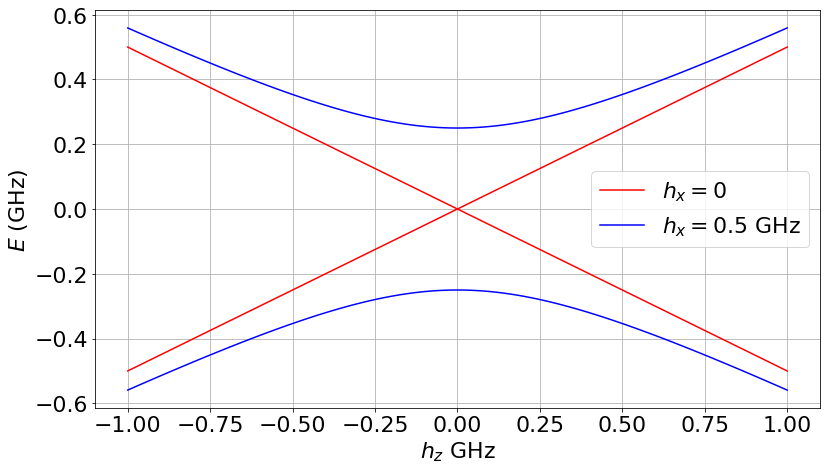

In [7]:
# Energies
hz = 0.5
hx = 0.5

# Get the spectrum against Z bias for a few values of X bias
hzs = np.linspace(-1,1,101)
hxs = np.array([0,0.5])
Evals00 = []
Evals01 = []
for hz in hzs:
    Hqb = hxs[0]*0.5*qt.sigmax() + hz*0.5*qt.sigmaz()
    E,s = Hqb.eigenstates()
    Evals00.append(E[0])
    Evals01.append(E[1])

Evals10 = []
Evals11 = []
for hz in hzs:
    Hqb = hxs[1]*0.5*qt.sigmax() + hz*0.5*qt.sigmaz()
    E,s = Hqb.eigenstates()
    Evals10.append(E[0])
    Evals11.append(E[1])

# Plot the spectra
fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
ax1.plot(hzs, Evals00,"r-",label="$h_x=0$")
ax1.plot(hzs, Evals01,"r-")
ax1.plot(hzs, Evals10,"b-",label="$h_x=0.5$ GHz")
ax1.plot(hzs, Evals11,"b-")
ax1.set_xlabel('$h_z$ GHz')
ax1.set_ylabel('$E$ (GHz)')
ax1.grid()
ax1.legend()
fig.tight_layout()


Now we will use the closed Jaynes-Cummings (JC) model of the interaction between the these two objects, which is expressed as

$$\hat{H}_\mathrm{JC} = \hat{H}_\mathrm{osc} + \hat{H}_\mathrm{qb} + \hbar g\left(\hat{a}^\dagger \hat{\sigma}^+ + \hat{\sigma}^- \hat{a}\right)$$

where the last term represents the interaction energy between the qubit and resonator, coupled with strength $g$. The raising and lowering qubit operators can be constructed from knowledge of the ground and excited states

$$\hat{\sigma}^+ = |g\rangle \langle e|$$
$$\hat{\sigma}^- = |e\rangle \langle g|$$

They have the following properties:

In [8]:
# Energies
hz = 0.5
hx = 0.0

# Qubit hamiltonian
Hqb = hx*0.5*qt.sigmax() + hz*0.5*qt.sigmaz()

# Transition operators
E,psi = Hqb.eigenstates()
sigma_l = psi[0]*psi[1].dag()
sigma_r = psi[1]*psi[0].dag()

print ("Lowering operator:")
display(sigma_l)
display(sigma_l * psi[0])
display(sigma_l * psi[1])

print ("Raising operator:")
display(sigma_r)
display(sigma_r * psi[0])
display(sigma_r * psi[1])

Lowering operator:


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 0.]
 [1. 0.]]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [0.]]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.]
 [-1.]]

Raising operator:


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-1.]
 [ 0.]]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [0.]]

To finalise the JC Hamiltonian, the qubit and resonator Hilbert spaces must be mixed

$$\hat{H}_\mathrm{JC} = \hat{H}_\mathrm{osc} \otimes \hat{I}_2 + \hat{I}_n \otimes \hat{H}_\mathrm{qb} + \hbar g\left(\hat{a}^\dagger \otimes \hat{\sigma}^- + \hat{a} \otimes \hat{\sigma}^+ \right)$$

where $n$ is the truncation used for the resonator states. This is also straight forward in qutip:

In [9]:
# Oscillator hamiltonian
htrunc = 5
omega_r = 2*np.pi*60
a = qt.destroy(htrunc)
Hosc = omega_r*(a.dag()*a+0.5)

# Qubit hamiltonian
hz = 0.0*2*np.pi
hx = 0.5*2*np.pi
Hqb = hx*0.5*qt.sigmax() + hz*0.5*qt.sigmaz()
Eqb,psi = Hqb.eigenstates()
sigma_l = psi[0]*psi[1].dag()
sigma_r = psi[1]*psi[0].dag()

# Interaction Hamiltonian
g = 0.2*2*np.pi # Coupling constant
Hint = g*(qt.tensor(a.dag(),sigma_l) + qt.tensor(a,sigma_r))

# Expand the Hilbert space to accomodate qubit and resonator states in final hamiltonian
Hjc = qt.tensor(Hosc,qt.qeye(2)) + qt.tensor(qt.qeye(htrunc),Hqb) + Hint
E,s = Hjc.eigenstates()
display(E)

gap = Eqb[1]-Eqb[0]
print ("Isolated QB gap = %e" % gap)

detuning = gap - omega_r
print ("Detuning = %e" % detuning)

shift_a = 2*g**2/detuning
print ("Analytical shift = %e" % shift_a)

jc_gap = E[1]-E[2]
print ("JC gap = %e" % jc_gap)

shift_n = jc_gap - detuning
print ("Numerical shift = %e" % shift_n)


array([ 186.92476289,  190.0621316 ,  563.92010526,  567.04902618,
        940.91544754,  944.03592086, 1317.91078972, 1321.02281564,
       1694.90613181, 1698.03082927])

Isolated QB gap = 3.141593e+00
Detuning = -3.738495e+02
Analytical shift = -8.447980e-03
JC gap = -3.738580e+02
Numerical shift = -8.447885e-03


We can now look at the effect of the tuning between the resonator and qubit frequencies, which can be expressed as a detuning parameter

$$\Delta = \sqrt{h_x^2 + h_z^2} - \omega_r$$

which defines different regimes of the composite system:

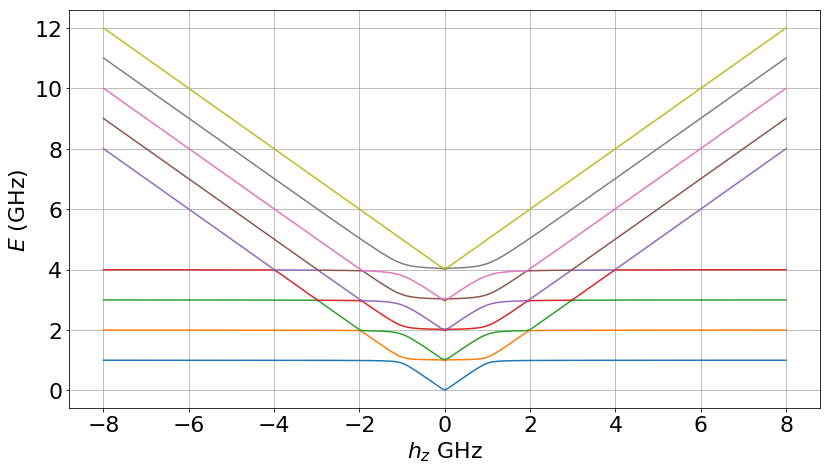

In [10]:
hx = 0*2*np.pi

# Oscillator hamiltonian
htrunc = 5
omega_r = 2*np.pi*1
a = qt.destroy(htrunc)
Hosc = omega_r*(a.dag()*a+0.5)

# 
hzs = np.linspace(-8,8,201)*2*np.pi
Evals = []
for hz in hzs:
    
    # Qubit hamiltonian
    Hqb = hx*0.5*qt.sigmax() + hz*0.5*qt.sigmaz()
    
    # Raising/Lowering operators
    E,psi = Hqb.eigenstates()
    sigma_l = psi[0]*psi[1].dag()
    sigma_r = psi[1]*psi[0].dag()

    # Interaction Hamiltonian
    g = 0.1*2*np.pi # Coupling constant
    Hint = g*(qt.tensor(a.dag(),sigma_l) + qt.tensor(a,sigma_r))

    # Expand the Hilbert space to accomodate qubit and resonator states in final hamiltonian
    Hjc = qt.tensor(Hosc,qt.qeye(2)) + qt.tensor(qt.qeye(htrunc),Hqb) + Hint
    E,s = Hjc.eigenstates()
    Evals.append(E)

# Transpose
Evals = np.array(Evals).T

fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
for Ev in Evals[1:]:
    ax1.plot(hzs/(2*np.pi), (Ev - Evals[0])/(2*np.pi))
ax1.set_xlabel('$h_z$ GHz')
ax1.set_ylabel('$E$ (GHz)')
ax1.grid()
#ax1.legend()
fig.tight_layout()

We then want to determine what the effective shift in the resonant frequency is as a function of the qubit parameters. We can see from the spectrum that interaction between the qubit and the resonator is very strong when their frequencies are resonant, i.e. $\sqrt{h_x^2 + h_z^2} = \omega_r$ where the splitting at this point is $2 g$. The analysis of the eigenenergies of the current JC Hamiltonian predicts that the shift in the resonant frequency is determined by

$$\omega_{r,\mathrm{eff}} = \omega_r \pm \frac{g^2}{\Delta}$$

which shows that we expect the shift to diverge when the resonant condition is achieved. In other words when the detuning between the qubit and resonator approaches zero. To calculate the shift from the results, we notice that first that the ground state is associated with the ground state of the qubit and an unpopulated resonator. To get an interaction the resonator must be populated with at least one photon. We can then compute the shift of the resonator from the detuning and the gap between the first and second excited states of the composite system. When $\Delta < 0$:

$$\omega_{r,\mathrm{eff}} = \omega_r - \Delta - \frac{1}{2}\left( E_{0,\downarrow} - E_{1,\uparrow} \right) $$

and when $\Delta > 0$:

$$\omega_{r,\mathrm{eff}} = \omega_r - \Delta + \frac{1}{2}\left( E_{0,\downarrow} - E_{1,\uparrow} \right) $$

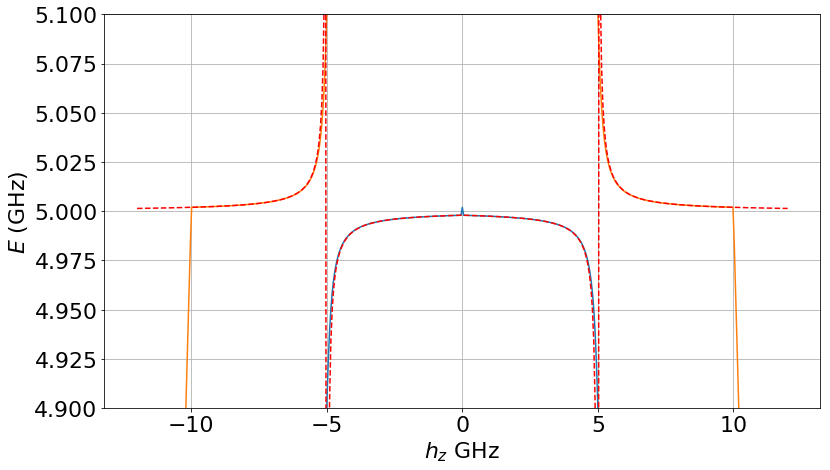

In [11]:
hx = 0.0*2*np.pi

# Oscillator hamiltonian
htrunc = 5
omega_r = 2*np.pi*5
a = qt.destroy(htrunc)
Hosc = omega_r*(a.dag()*a+0.5)

# 
hzs = np.linspace(-12,12,501)*2*np.pi
omega_vals = []
omega_vals2 = []
omega_vals_t = []
for hz in hzs:
    
    # Qubit hamiltonian
    Hqb = hx*0.5*qt.sigmax() + hz*0.5*qt.sigmaz()
    
    # Raising/Lowering operators
    Eqb,psi = Hqb.eigenstates()
    sigma_l = psi[0]*psi[1].dag()
    sigma_r = psi[1]*psi[0].dag()

    # Interaction Hamiltonian
    g = 0.1*2*np.pi # Coupling constant
    Hint = g*(qt.tensor(a.dag(),sigma_l) + qt.tensor(a,sigma_r))

    # Expand the Hilbert space to accomodate qubit and resonator states in final hamiltonian
    Hjc = qt.tensor(Hosc,qt.qeye(2)) + qt.tensor(qt.qeye(htrunc),Hqb) + Hint
    E,s = Hjc.eigenstates()
    
    # Calculate the isolated qubit energy gap
    qb_gap = Eqb[1] - Eqb[0]
    
    # Get detuning
    detuning = qb_gap - omega_r
    
    # Calculate the gap between the two lowest states with a single photon
    jc_gap = qt.expect(Hjc,s[2])-qt.expect(Hjc,s[1])
    
    # Get the shift (numerical)
    shift = jc_gap + detuning
    omega_vals.append(omega_r - shift/2)
    
    shift = jc_gap - detuning
    omega_vals2.append(omega_r + shift/2)
    
    # Get the shift (analytical)
    omega_vals_t.append(omega_r + g**2/detuning)

# Convert
omega_vals = np.array(omega_vals)
omega_vals2 = np.array(omega_vals2)
omega_vals_t = np.array(omega_vals_t)

fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
#for omega in omega_vals:
ax1.plot(hzs/(2*np.pi), omega_vals/(2*np.pi))
ax1.plot(hzs/(2*np.pi), omega_vals2/(2*np.pi))
ax1.plot(hzs/(2*np.pi), omega_vals_t/(2*np.pi),"r--")
ax1.set_xlabel('$h_z$ GHz')
ax1.set_ylabel('$E$ (GHz)')
ax1.set_ylim([4.9,5.1])
ax1.grid()
#ax1.legend()
fig.tight_layout()

### Adding Periodicity to Spin Model

To add periodicity to the spin level Hamiltonian, we can use the following construction:

$$\hat{H}_\mathrm{qb} = \frac{\hbar}{2}\left( h_z(\phi_z) \hat{\sigma}_z + h_x(\phi_x) \hat{\sigma}_x \right)$$

where $h_x$ and $h_z$ can be made periodic through dependence on (fictional) external fluxes $\phi_x$ and $\phi_z$. The simplest form we could choose for the periodic functions is:

$$h_{x,z}(\phi_{x,z}) = h_{x,z}\left(\frac{1}{2} - \frac{1}{2} \cos(2\pi\phi_{x,z}) \right)$$

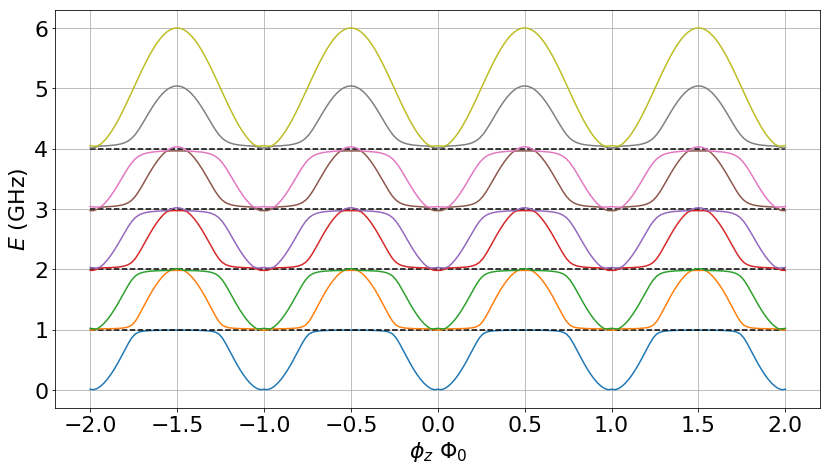

In [12]:
hx = 0*2*np.pi
hz = 4*np.pi

# Flux dependence
def hxf(xflux,hx,freq):
    return hx*(0.5-0.5*np.cos(freq*2*np.pi*xflux))

def hzf(zflux,hz,freq):
    return hz*(0.5-0.5*np.cos(freq*2*np.pi*zflux))

# Oscillator hamiltonian
htrunc = 5
omega_r = 2*np.pi*1
a = qt.destroy(htrunc)
Hosc = omega_r*(a.dag()*a+0.5)

# 
zfluxs = np.linspace(-2,2,201)
Evals = []
for zflux in zfluxs:
    
    # Qubit hamiltonian
    Hqb = hxf(0,hx,1)*0.5*qt.sigmax() + hzf(zflux,hz,1)*0.5*qt.sigmaz()
    
    # Raising/Lowering operators
    E,psi = Hqb.eigenstates()
    sigma_l = psi[0]*psi[1].dag()
    sigma_r = psi[1]*psi[0].dag()

    # Interaction Hamiltonian
    g = 0.1*2*np.pi # Coupling constant
    Hint = g*(qt.tensor(a.dag(),sigma_l) + qt.tensor(a,sigma_r))

    # Expand the Hilbert space to accomodate qubit and resonator states in final hamiltonian
    Hjc = qt.tensor(Hosc,qt.qeye(2)) + qt.tensor(qt.qeye(htrunc),Hqb) + Hint
    E,s = Hjc.eigenstates()
    Evals.append(E)

# Transpose
Evals = np.array(Evals).T

fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
i = 1
for Ev in Evals[1:]:
    ax1.plot(zfluxs, (Ev - Evals[0])/(2*np.pi))
    if i < htrunc:
        ax1.plot([zfluxs[0],zfluxs[-1]],[i*omega_r/(np.pi*2),i*omega_r/(np.pi*2)],"k--")
    i+=1
ax1.set_xlabel('$\phi_z$ $\Phi_0$')
ax1.set_ylabel('$E$ (GHz)')
ax1.grid()
#ax1.legend()
fig.tight_layout()

Now we can look at the periodicity of the resonator modulation:

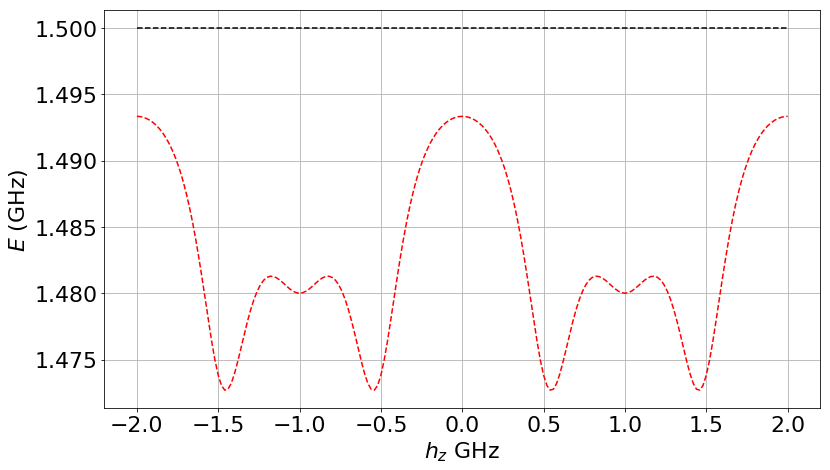

In [13]:
hx = 2*np.pi
hz = 2*np.pi

# Flux dependence
def hxf(xflux,hx,freq):
    return hx*(0.5-0.5*np.cos(freq*np.pi*xflux))

def hzf(zflux,hz,freq):
    return hz*(0.5-0.5*np.cos(freq*2*np.pi*zflux))

#def hzf(zflux,hz,freq):
#    return hz*np.cos(freq*np.pi*zflux)**2

# Oscillator hamiltonian
htrunc = 5
omega_r = 2*np.pi*1.5
a = qt.destroy(htrunc)
Hosc = omega_r*(a.dag()*a+0.5)

# 
zfluxs = np.linspace(-2,2,201)
omega_vals = []
omega_vals2 = []
omega_vals_t = []
for zflux in zfluxs:
    
    # Qubit hamiltonian
    Hqb = hxf(zflux,hx,1)*0.5*qt.sigmax() + hzf(zflux,hz,1)*0.5*qt.sigmaz()
    
    # Raising/Lowering operators
    Eqb,psi = Hqb.eigenstates()
    sigma_l = psi[0]*psi[1].dag()
    sigma_r = psi[1]*psi[0].dag()

    # Interaction Hamiltonian
    g = 0.1*2*np.pi # Coupling constant
    Hint = g*(qt.tensor(a.dag(),sigma_l) + qt.tensor(a,sigma_r))

    # Expand the Hilbert space to accomodate qubit and resonator states in final hamiltonian
    Hjc = qt.tensor(Hosc,qt.qeye(2)) + qt.tensor(qt.qeye(htrunc),Hqb) + Hint
    E,s = Hjc.eigenstates()
    
    # Calculate the isolated qubit energy gap
    qb_gap = Eqb[1] - Eqb[0]
    
    # Get detuning
    detuning = qb_gap - omega_r
    
    # Calculate the gap between the two lowest states with a single photon
    jc_gap = qt.expect(Hjc,s[2])-qt.expect(Hjc,s[1])
    
    # Get the shift (numerical)
    shift = jc_gap + detuning
    omega_vals.append(omega_r - shift/2)
    
    shift = jc_gap - detuning
    omega_vals2.append(omega_r + shift/2)
    
    # Get the shift (analytical)
    omega_vals_t.append(omega_r + g**2/detuning)

# Convert
omega_vals = np.array(omega_vals)
omega_vals2 = np.array(omega_vals2)
omega_vals_t = np.array(omega_vals_t)

fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
#for omega in omega_vals:
#ax1.plot(zfluxs, omega_vals/(2*np.pi))
#ax1.plot(zfluxs, omega_vals2/(2*np.pi))
ax1.plot(zfluxs, omega_vals_t/(2*np.pi),"r--")
ax1.plot([zfluxs[0],zfluxs[-1]],[omega_r/(np.pi*2),omega_r/(np.pi*2)],"k--")
ax1.set_xlabel('$h_z$ GHz')
ax1.set_ylabel('$E$ (GHz)')
#ax1.set_ylim([0,3])
ax1.grid()
#ax1.legend()
fig.tight_layout()

### CSFQ Coupled to Resonator

Now we would like to find the resonator modulation associated with a resonator coupled to a CSFQ. If the resonator is coupled capacitively through the shunt capacitor, the coupling is between the charge degrees of freedom of the CSFQ and the resonator. The circuit is shown in simplified equivalent circuit diagram below:

<img src="CSFQ-LC-Circuit.png" height="50">

A number of assumptions are made about this circuit to simplify analysis. First, all the stray capacitances around the CSFQ, including the capacitance of the junctions are assumed to be lumped into $C_\mathrm{sh}$, and all those around the resonator, into $C_\mathrm{r}$. Second, we approximate the capacitance seen by the resonator and the qubit by assuming that $C_\mathrm{g} \ll C_\mathrm{r},C_\mathrm{sh}$. The total qubit capacitance is then written as

$$C_\mathrm{qb} = C_\mathrm{sh} + \frac{C_\mathrm{g} C_\mathrm{r}}{C_\mathrm{g} + C_\mathrm{r}} \approx C_\mathrm{sh} + C_\mathrm{g}$$

and similarly for the resonator

$$C_\mathrm{r,eff} = C_\mathrm{r} + \frac{C_\mathrm{g} C_\mathrm{sh}}{C_\mathrm{g} + C_\mathrm{sh}} \approx C_\mathrm{r} + C_\mathrm{g}$$

from which we can derive the resonant frequency of the resonator

$$\omega_{r} = \frac{1}{\sqrt{L_\mathrm{r} C_\mathrm{r,eff}}} \cdot$$

To derive the coupling, we determine the energy contributions due to each capacitor expressed in terms of only the resonator and qubit charges. For these the energies are simply $q_\mathrm{sh}^2/2C_\mathrm{sh}$ and $q_\mathrm{r}^2/2C_\mathrm{r}$. The coupling term is determined by considering the voltages across each branch and using $\frac{1}{2}C_\mathrm{g} V_\mathrm{g}^2$. Since $V_\mathrm{g} = V_\mathrm{sh} - V_\mathrm{r}$ and $V_\mathrm{sh,r} = q_\mathrm{sh,r}/C_\mathrm{sh,r}$, we find

$$U_\mathrm{q} = \frac{q_\mathrm{sh}^2}{2C_\mathrm{sh}} + \frac{q_\mathrm{r}^2}{2C_\mathrm{r}} - \frac{C_\mathrm{g}}{2}\left( \frac{q_\mathrm{sh}}{C_\mathrm{sh}} - \frac{q_\mathrm{r}}{C_\mathrm{r}} \right)^2$$

which is simplified in terms of the charges to read

$$U_\mathrm{q} = \frac{q_\mathrm{sh}^2}{2C_\mathrm{sh}}\left(1 - \frac{C_\mathrm{g}}{C_\mathrm{sh}}\right) + \frac{q_\mathrm{r}^2}{2C_\mathrm{r}}\left(1 - \frac{C_\mathrm{g}}{C_\mathrm{r}}\right) + \frac{C_\mathrm{g}}{C_\mathrm{r} C_\mathrm{sh}} q_\mathrm{sh} q_\mathrm{r}$$

where the last term is the interaction term.

Now we can contributions of all elements to the total energy. The derivation of the CSFQ degrees of freedom is documented above (tba) and is done in the same way. The energies of the JJs in the CSFQ read, as before

$$U_\mathrm{J} = -2E_\mathrm{J}\cos\left(\phi\right) +\alpha E_\mathrm{J}\cos\left(\frac{\phi_x}{2}\right)\cos\left(2\phi + \phi_z\right)$$

where the $\phi$ degree of freedom results from the same simplifications. The only inductive contribution is due to resonator, since the CSFQ inductances have dropped out following the assumption that the external fluxes are locked due the small inductance values

$$U_\mathrm{L} = \frac{\Phi_0^2 \phi_\mathrm{r}^2}{8\pi^2 L_\mathrm{r}} \cdot$$

Now we want to express the Lagrangian of the circuit to then derive the Hamiltonian, where we cast the electrostatic energy as the kinetic energy and use the fluxes as the coordinate variables

$$q_\mathrm{sh} \rightarrow \dot{\phi}$$
$$q_\mathrm{r} \rightarrow \dot{\phi}_\mathrm{r}$$

thus

$$\mathcal{L}\left( \dot{\phi}, \dot{\phi}_\mathrm{r}, \phi, \phi_\mathrm{r} \right) = U_\mathrm{q} - U_\mathrm{J} - U_\mathrm{L}$$

then we can find the canonical variable pairs by taking the derivatives of the Lagrangian with respect to each variable

$$p = \frac{\partial \mathcal{L}}{\partial \dot{\phi}} = \dot{\phi}\frac{1}{C_\mathrm{sh}}\left(1 - \frac{C_\mathrm{g}}{C_\mathrm{sh}}\right) + \dot{\phi}_\mathrm{r} \frac{C_\mathrm{g}}{C_\mathrm{r} C_\mathrm{sh}}$$

and

$$p_\mathrm{r} = \frac{\partial \mathcal{L}}{\partial \dot{\phi}_\mathrm{r}} = \dot{\phi}_\mathrm{r} \frac{1}{C_\mathrm{r}}\left(1 - \frac{C_\mathrm{g}}{C_\mathrm{r}}\right) + \dot{\phi} \frac{C_\mathrm{g}}{C_\mathrm{r} C_\mathrm{sh}}$$

where we can see that the capacitors play the role of inverse-mass. Then we use the Legendre transformation to find the classical Hamiltonian of the circuit

$$H = \sum_i \dot{\phi}_i p_i - \mathcal{L}$$

For this particular circuit, we find that $\sum_i \dot{\phi}_i p_i = 2U_\mathrm{q}$, so that the Hamiltonian is simply

$$H = U_\mathrm{q} + U_\mathrm{J} + U_\mathrm{L}$$

as expected. We can now separate the Hamiltonian in terms of the involved subsystems, including the CSFQ, the resonator, and the interaction between them:

$$H = H_\mathrm{CSFQ} + H_\mathrm{osc} + H_\mathrm{int}$$

where

$$H_\mathrm{osc} = \frac{\dot{\phi}_\mathrm{r}}{2 C_\mathrm{r}}\left(1 - \frac{C_\mathrm{g}}{C_\mathrm{r}}\right) + \frac{\Phi_0^2 \phi_\mathrm{r}^2}{8\pi^2 L_\mathrm{r}}$$

and

$$H_\mathrm{int} = \frac{C_\mathrm{g}}{C_\mathrm{r} C_\mathrm{sh}} \dot{\phi} \dot{\phi}_\mathrm{r}$$

Now we can quantise the degrees of freedom of the circuit as follows

$$\dot{\phi} \rightarrow \hat{n}$$
$$\phi \rightarrow \hat{\phi}$$

The next step is to express the oscillator Hamiltonian in terms of creation and annihilation operators. To do this we can see that

$$\frac{1}{C_\mathrm{r}} - \frac{C_\mathrm{g}}{C_\mathrm{r}^2} \approx \frac{1}{C_\mathrm{r} + C_\mathrm{g}}$$

which allows us to define the usual harmonic oscillator operators in terms of the resonant frequency and impedance of the resonator

$$\omega_{r} = \frac{1}{\sqrt{L_\mathrm{r} \left( C_\mathrm{r} + C_\mathrm{g} \right)}}$$

and

$$Z_\mathrm{r} = \sqrt{\frac{L_\mathrm{r}}{C_\mathrm{r} + C_\mathrm{g}}}$$

respectively. The annihilation and creation are then defined as

$$\hat{a}^\dagger = \hat{\phi}_\mathrm{r} \frac{1}{2} \sqrt{\frac{1}{2 Z_\mathrm{r}}} + i\hat{n}_\mathrm{r} \frac{1}{2} \sqrt{\frac{Z_\mathrm{r}}{2}} $$

and

$$\hat{a} = \hat{\phi}_\mathrm{r} \frac{1}{2} \sqrt{\frac{1}{2 Z_\mathrm{r}}} - i\hat{n}_\mathrm{r} \frac{1}{2} \sqrt{\frac{Z_\mathrm{r}}{2}} $$

respectively. The oscillator Hamiltonian can then be written in terms of these operators as

$$\hat{H}_\mathrm{osc} = \frac{1}{2}\hbar \omega_\mathrm{r} \left( \hat{a}\hat{a}^\dagger + \hat{a}^\dagger\hat{a} \right) = \hbar\omega_\mathrm{r}\left( \hat{a}^\dagger\hat{a} + \frac{1}{2} \right)$$

We can now choose a basis to define the elements of the operators. Using the oscillator basis is convenient as it is similar to the charge basis. In this basis, the interaction term can then be written as

$$\hat{H}_\mathrm{int} = \frac{C_\mathrm{g}}{C_\mathrm{r} C_\mathrm{sh}} \hat{n} \hat{n}_\mathrm{r}$$

where now we can express the oscillator charge in terms of annihilation and creation operators:

$$\hat{n}_\mathrm{r} = -i \sqrt{\frac{1}{2 Z_\mathrm{r}}}\left( \hat{a}^\dagger - \hat{a} \right) \cdot$$

Now we can define the coupling constant as

$$g = \sqrt{\frac{1}{2 Z_\mathrm{r}}}\frac{C_\mathrm{g}}{C_\mathrm{r} C_\mathrm{sh}}$$

which reduces the interaction Hamiltonian to

$$\hat{H}_\mathrm{int} = -i g \hat{n} \left( \hat{a}^\dagger - \hat{a} \right) \cdot$$

Now we can describe the composite resonator-CSFQ system with the following Hamiltonian:

$$\hat{H}_\mathrm{JC} = \hat{H}_\mathrm{osc} \otimes \hat{I}\left(n_\mathrm{CSFQ}\right) + \hat{I}\left(n_\mathrm{osc}\right) \otimes \hat{H}_\mathrm{CSFQ} - i \hbar g \hat{n} \otimes\left(\hat{a}^\dagger - \hat{a}\right)$$

where we will only use a few resonator states to minimise the size of the Hilbert space.

In [29]:
# Create qubits
qubit3_params = {"Ajj":0.36*0.2,"alpha":0.84,"Jc":2.4,"Ca":60,"Csh":220e-15,"trunc":80}
qubit3 = CSFQ_Qubit(qubit3_params)
qubit3.info()

# Oscillator hamiltonian
htrunc = 4
omega_r = 5
a = qt.destroy(htrunc)
Hosc = omega_r*(a.dag()*a+0.5)

# Interaction Hamiltonian
g = -0.1j # Coupling constant
Hint = g*qt.tensor((a.dag() - a),qubit3.op_charge_number())

# Z flux points
zflux = np.linspace(-0.1*np.pi,0.1*np.pi,201)

# Setup progress bar
f = FloatProgress(min=0, max=len(zflux))
print("zflux sweep progress:")
display(f)

# Do computation
Evals = []
omega_vals = []
omega_vals2 = []
for zf in zflux:

    # Get qubit H at specific bias point
    Hqb = qubit3.op_hamiltonian(0.5*np.pi,zf,ret=True)
    Eqb,psi = Hqb.eigenstates()
    
    # Expand the Hilbert space to accomodate qubit and resonator states in final hamiltonian
    Hjc = qt.tensor(Hosc,qt.qeye(qubit3_params["trunc"])) + qt.tensor(qt.qeye(htrunc),Hqb) + Hint
    E,s = Hjc.eigenstates()
    Evals.append(E)
    
    # Calculate the isolated qubit energy gap
    qb_gap = Eqb[1] - Eqb[0]
    
    # Get detuning
    detuning = qb_gap - omega_r
    
    # Calculate the gap between the two lowest states with a single photon
    jc_gap = qt.expect(Hjc,s[2])-qt.expect(Hjc,s[1])
    
    # Get the shift (numerical)
    shift = jc_gap + detuning
    omega_vals.append(omega_r - shift/2)
    
    shift = jc_gap - detuning
    omega_vals2.append(omega_r + shift/2)
    
    f.value+=1

# Transpose
Evals = np.array(Evals).T


[Ajj] = 7.200000e-02
[alpha] = 8.400000e-01
[Jc] = 2.400000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.257888e-13 F
[Ec] = 3.431566e-01 GHz
[Ej (large)] = 8.582691e+01 GHz
[Ej (small)] = 7.209461e+01 GHz
[Ej/Ec] = 210.1

zflux sweep progress:


FloatProgress(value=0.0, max=201.0)

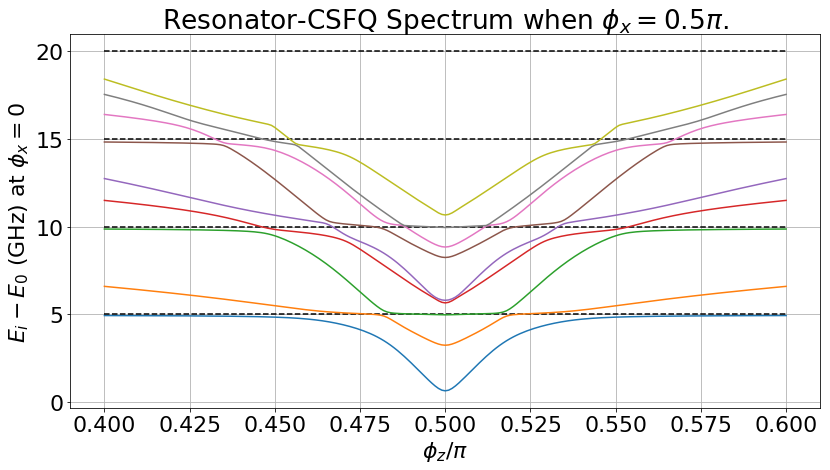

In [30]:
fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
i = 1
for Ev in Evals[1:10]:
    ax1.plot(zflux/np.pi+0.5, (Ev - Evals[0]))
    if i < 5:
        ax1.plot([zflux[0]/np.pi+0.5,zflux[-1]/np.pi+0.5],[i*omega_r,i*omega_r],"k--")
    i+=1
ax1.set_title("Resonator-CSFQ Spectrum when $\phi_x = 0.5\pi$.")
ax1.set_xlabel('$\phi_z/\pi$')
ax1.set_ylabel('$E_i-E_0$ (GHz) at $\phi_x = 0$')
ax1.grid()
#ax1.legend()
fig.tight_layout()

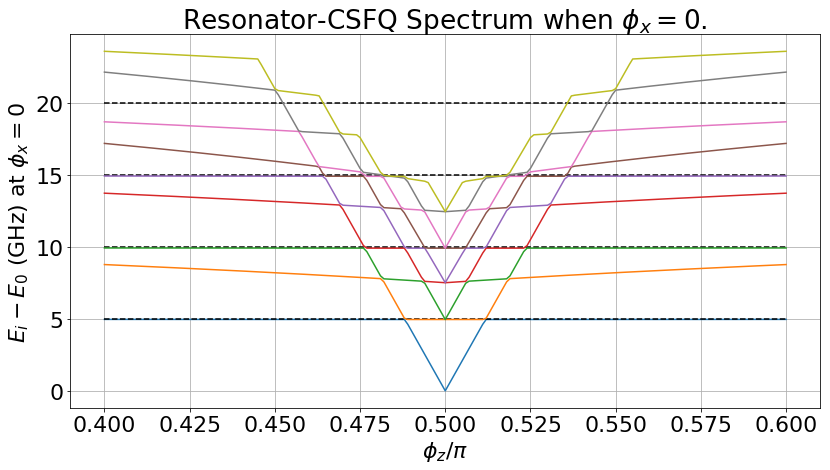

In [26]:
fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
i = 1
for Ev in Evals[1:10]:
    ax1.plot(zflux/np.pi+0.5, (Ev - Evals[0]))
    if i < 5:
        ax1.plot([zflux[0]/np.pi+0.5,zflux[-1]/np.pi+0.5],[i*omega_r,i*omega_r],"k--")
    i+=1
ax1.set_title("Resonator-CSFQ Spectrum when $\phi_x = 0$.")
ax1.set_xlabel('$\phi_z/\pi$')
ax1.set_ylabel('$E_i-E_0$ (GHz) at $\phi_x = 0$')
ax1.grid()
#ax1.legend()
fig.tight_layout()

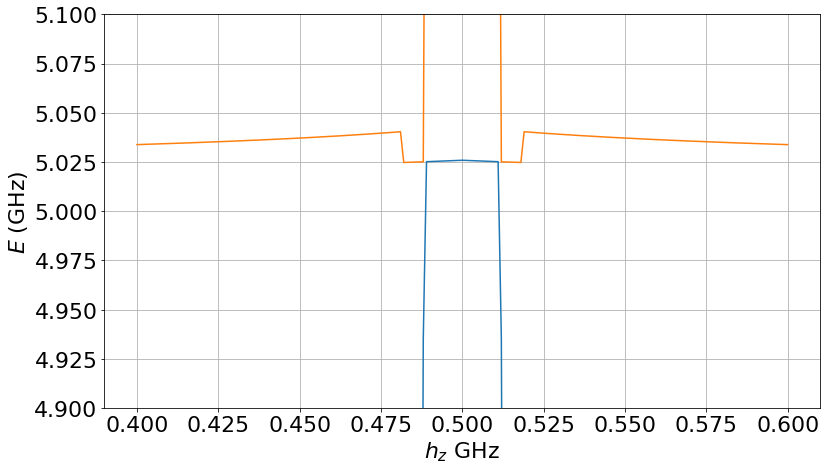

In [28]:
# Convert
omega_vals = np.array(omega_vals)
omega_vals2 = np.array(omega_vals2)
#omega_vals_t = np.array(omega_vals_t)

fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
#for omega in omega_vals:
ax1.plot(zflux/np.pi+0.5, omega_vals)
ax1.plot(zflux/np.pi+0.5, omega_vals2)
#ax1.plot(hzs/(2*np.pi), omega_vals_t/(2*np.pi),"r--")
ax1.set_xlabel('$h_z$ GHz')
ax1.set_ylabel('$E$ (GHz)')
ax1.set_ylim([4.9,5.1])
ax1.grid()
#ax1.legend()
fig.tight_layout()

## Using the JC Ladder

To estimate the coupling strength when there are many photons in the cavity, the JC ladder model proposed by [D. Sank *et al*][1] can be used. In this work the authors show that this model accounts for the measurement-induced state transitions that occur when the photon number in the resonator is high.

The idea in this model is express the JC Hamiltonian in the basis of qubit eigenstates and expressing the interaction term as a function of the number of photons in the cavity. This way one can keep the Hilbert space of the resonator small by only using those states at that high number of photons. Here, the qubit Hamiltonian in the qubit basis is simply obtained by diagonalising the CSFQ Hamiltonian to obtain the eigenenergies and eigenstates, which leads to

$$\hat{H}_\mathrm{qb} = \sum_k E_k\left| k \rangle \langle k \right|$$

which must be evaluated for every flux bias point. Then the interaction term in this basis is expressed as

$$\hat{H}_\mathrm{int} = \sum_{k,k',n} \hbar g_{k,k'} \sqrt{n}\left( \left| k',n-1 \rangle \langle k,n \right| + \left| k,n \rangle \langle k',n-1 \right| \right)$$

where the coupling terms are determined from the qubit state coupling terms involved in the interaction, in this case

$$g_{k,k'} = g\frac{\langle k \left|\hat{n}\right| k' \rangle}{\langle 0 \left|\hat{n}\right| 1 \rangle}$$

since the coupling is through the charge operator of the qubit. The composite qubit-resonator system eigenstates can be constructed with tensor products

$$| k,n \rangle = | k \rangle \otimes |n \rangle$$

where the resonator states are taken in the usual Foch basis.

First we can look at the dependence of the $g_{k,k'}$ terms against X and Z flux:

[1]: https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.117.190503

[Ajj] = 7.200000e-02
[alpha] = 8.400000e-01
[Jc] = 2.400000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.257888e-13 F
[Ec] = 3.431566e-01 GHz
[Ej (large)] = 8.582691e+01 GHz
[Ej (small)] = 7.209461e+01 GHz
[Ej/Ec] = 210.1

zflux sweep progress:


FloatProgress(value=0.0, max=201.0)

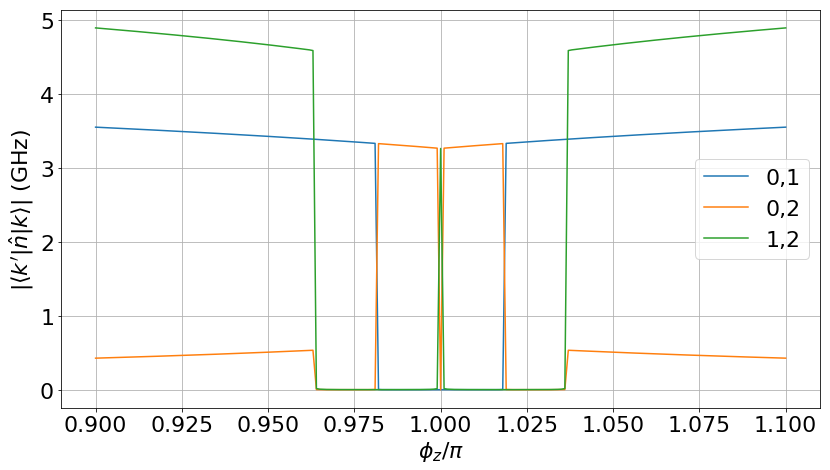

In [21]:
# Create qubits
qubit3_params = {"Ajj":0.36*0.2,"alpha":0.84,"Jc":2.4,"Ca":60,"Csh":220e-15,"trunc":80}
qubit3 = CSFQ_Qubit(qubit3_params)
qubit3.info()

# Z flux points
zflux = np.linspace(-0.1*np.pi,0.1*np.pi,201)

# Setup progress bar
f = FloatProgress(min=0, max=len(zflux))
print("zflux sweep progress:")
display(f)

# Do computation
gz_vals1 = []
gz_vals2 = []
gz_vals3 = []
for zf in zflux:

    # Get qubit H at specific bias point
    Hqb = qubit3.op_hamiltonian(0,zf,ret=True)
    Eqb,psi = Hqb.eigenstates()
    
    # Calculate the lowest energy coupling terms
    gz_vals1.append((psi[0].dag()*qubit3.op_charge_number()*psi[1])[0][0])
    gz_vals2.append((psi[0].dag()*qubit3.op_charge_number()*psi[2])[0][0])
    gz_vals3.append((psi[1].dag()*qubit3.op_charge_number()*psi[2])[0][0])
    
    f.value+=1

# Convert
gz_vals1 = np.abs(np.array(gz_vals1))
gz_vals2 = np.abs(np.array(gz_vals2))
gz_vals3 = np.abs(np.array(gz_vals3))

fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
ax1.plot(zflux/np.pi+1, gz_vals1,label="0,1")
ax1.plot(zflux/np.pi+1, gz_vals2,label="0,2")
ax1.plot(zflux/np.pi+1, gz_vals3,label="1,2")
ax1.set_xlabel('$\phi_z/\pi$')
ax1.set_ylabel('$ \\left|\\langle k\' \\left|\\hat{n}\\right| k \\rangle\\right|$ (GHz)')
ax1.grid()
ax1.legend()
fig.tight_layout()

[Ajj] = 7.200000e-02
[alpha] = 8.400000e-01
[Jc] = 2.400000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.257888e-13 F
[Ec] = 3.431566e-01 GHz
[Ej (large)] = 8.582691e+01 GHz
[Ej (small)] = 7.209461e+01 GHz
[Ej/Ec] = 210.1

zflux sweep progress:


FloatProgress(value=0.0, max=201.0)

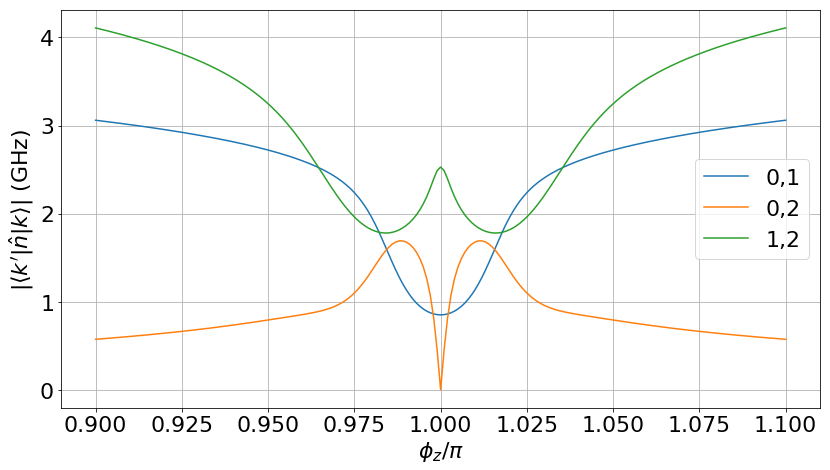

In [27]:
# Create qubits
qubit3_params = {"Ajj":0.36*0.2,"alpha":0.84,"Jc":2.4,"Ca":60,"Csh":220e-15,"trunc":80}
qubit3 = CSFQ_Qubit(qubit3_params)
qubit3.info()

# Z flux points
zflux = np.linspace(-0.1*np.pi,0.1*np.pi,201)

# Setup progress bar
f = FloatProgress(min=0, max=len(zflux))
print("zflux sweep progress:")
display(f)

# Do computation
gz_vals1 = []
gz_vals2 = []
gz_vals3 = []
for zf in zflux:

    # Get qubit H at specific bias point
    Hqb = qubit3.op_hamiltonian(0.5*np.pi,zf,ret=True)
    Eqb,psi = Hqb.eigenstates()
    
    # Calculate the lowest energy coupling terms
    gz_vals1.append((psi[0].dag()*qubit3.op_charge_number()*psi[1])[0][0])
    gz_vals2.append((psi[0].dag()*qubit3.op_charge_number()*psi[2])[0][0])
    gz_vals3.append((psi[1].dag()*qubit3.op_charge_number()*psi[2])[0][0])
    
    f.value+=1

# Convert
gz_vals1 = np.abs(np.array(gz_vals1))
gz_vals2 = np.abs(np.array(gz_vals2))
gz_vals3 = np.abs(np.array(gz_vals3))

fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
ax1.plot(zflux/np.pi+1, gz_vals1,label="0,1")
ax1.plot(zflux/np.pi+1, gz_vals2,label="0,2")
ax1.plot(zflux/np.pi+1, gz_vals3,label="1,2")
ax1.set_xlabel('$\phi_z/\pi$')
ax1.set_ylabel('$ \\left|\\langle k\' \\left|\\hat{n}\\right| k \\rangle\\right|$ (GHz)')
ax1.grid()
ax1.legend()
fig.tight_layout()

## Using Mostafa's JC Ladder Code

In [24]:
import JC

In [58]:
phiz = np.linspace(-4*np.pi,4*np.pi,601)

# Qubit def
qubit1_params = {"Ajj":0.31*0.2,"alpha":0.97,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

# Resonator params
nmax = 5
omega_r = 7.5
g0 = 0.02

# Resonator modulation against Z
# Progress
f = FloatProgress(min=0, max=(len(phiz)))
print("Z JC sweep progress:")
display(f)

# Do the sweep
x = 0*2*np.pi
g_list = []
omega_eff = []
for z in phiz:
    Ei,psii = qubit1.op_hamiltonian(x,z,ret=True).eigenstates()
    
    # Get RWA coupling terms for JC
    g_list = []
    for i in range(len(Ei)-1):
        g = (psii[i].dag()*qubit1.op_charge_number()*psii[i+1])[0][0][0]
        g_list.append(np.abs(g))
    
    # Diagonalise RWA strip
    Erwa, psirwa = JC.diagonalize_ladder(nmax, omega_r, Ei-Ei[0], g0*np.array(g_list))
    response = JC.get_res_response(Erwa)
    omega_eff.append(response[0][0])
    
    f.value += 1


[Ajj] = 6.200000e-02
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.254684e-13 F
[Ec] = 3.436442e-01 GHz
[Ej (large)] = 9.238313e+01 GHz
[Ej (small)] = 8.961164e+01 GHz
[Ej/Ec] = 260.8

Z JC sweep progress:


FloatProgress(value=0.0, max=601.0)

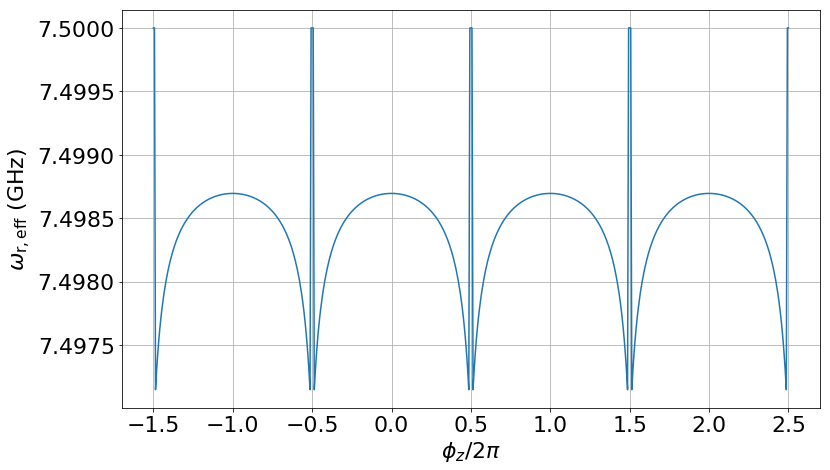

In [60]:
fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
ax1.plot(phiz/(2*np.pi)+0.5, omega_eff)
ax1.set_xlabel('$\\phi_z/2\\pi$')
ax1.set_ylabel('$\\omega_\\mathrm{r,eff}$ (GHz)')
ax1.grid()
#ax1.set_ylim([7.4,7.55])
fig.tight_layout()

In [68]:
phiz = np.linspace(-4*np.pi,4*np.pi,601)

# Qubit def
qubit1_params = {"Ajj":0.31*0.2,"alpha":0.97,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

# Resonator params
nmax = 5
omega_r = 7.5
g0 = 0.02

# Resonator modulation against X
# Progress
f = FloatProgress(min=0, max=(len(phiz)))
print("Z JC sweep progress:")
display(f)

# Do the sweep
x = 0*2*np.pi
g_list = []
omega_eff = []
for z in phiz:
    Ei,psii = qubit1.op_hamiltonian(z,x,ret=True).eigenstates()
    
    # Get RWA coupling terms for JC
    g_list = []
    for i in range(len(Ei)-1):
        g = (psii[i].dag()*qubit1.op_charge_number()*psii[i+1])[0][0][0]
        g_list.append(np.abs(g))
    
    # Diagonalise RWA strip
    Erwa, psirwa = JC.diagonalize_ladder(nmax, omega_r, Ei-Ei[0], g0*np.array(g_list))
    response = JC.get_res_response(Erwa)
    omega_eff.append(response[0][0])
    
    f.value += 1


[Ajj] = 6.200000e-02
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.254684e-13 F
[Ec] = 3.436442e-01 GHz
[Ej (large)] = 9.238313e+01 GHz
[Ej (small)] = 8.961164e+01 GHz
[Ej/Ec] = 260.8

Z JC sweep progress:


FloatProgress(value=0.0, max=601.0)

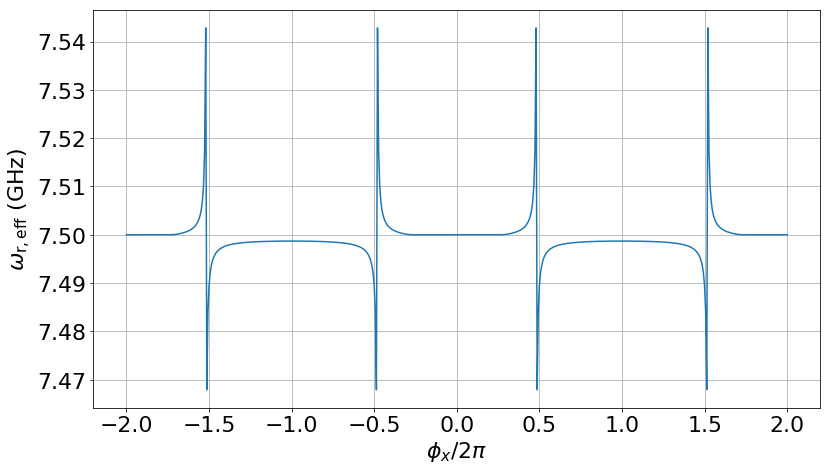

In [69]:
fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
ax1.plot(phiz/(2*np.pi), omega_eff)
ax1.set_xlabel('$\\phi_x/2\\pi$')
ax1.set_ylabel('$\\omega_\\mathrm{r,eff}$ (GHz)')
ax1.grid()
#ax1.set_ylim([7.4,7.6])
fig.tight_layout()

In [74]:
phiz = np.linspace(-4*np.pi,4*np.pi,601)

# Qubit def
qubit1_params = {"Ajj":0.31*0.2,"alpha":0.97,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

# Resonator params
nmax = 5
omega_r = 7.5
g0 = 0.02

# Resonator modulation against X
# Progress
f = FloatProgress(min=0, max=(len(phiz)))
print("Z JC sweep progress:")
display(f)

# Do the sweep
x = 0.2*2*np.pi
g_list = []
omega_eff = []
for z in phiz:
    Ei,psii = qubit1.op_hamiltonian(z,x,ret=True).eigenstates()
    
    # Get RWA coupling terms for JC
    g_list = []
    for i in range(len(Ei)-1):
        g = (psii[i].dag()*qubit1.op_charge_number()*psii[i+1])[0][0][0]
        g_list.append(np.abs(g))
    
    # Diagonalise RWA strip
    Erwa, psirwa = JC.diagonalize_ladder(nmax, omega_r, Ei-Ei[0], g0*np.array(g_list))
    response = JC.get_res_response(Erwa)
    omega_eff.append(response[0][0])
    
    f.value += 1


[Ajj] = 6.200000e-02
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.254684e-13 F
[Ec] = 3.436442e-01 GHz
[Ej (large)] = 9.238313e+01 GHz
[Ej (small)] = 8.961164e+01 GHz
[Ej/Ec] = 260.8

Z JC sweep progress:


FloatProgress(value=0.0, max=601.0)

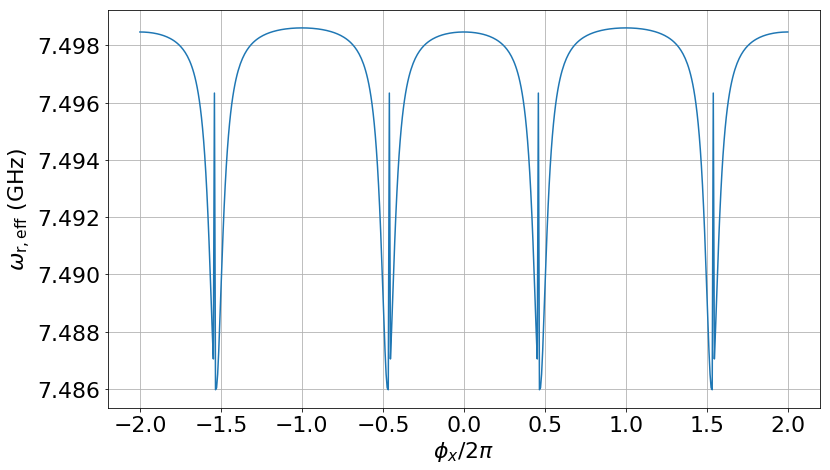

In [75]:
fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
ax1.plot(phiz/(2*np.pi), omega_eff)
ax1.set_xlabel('$\\phi_x/2\\pi$')
ax1.set_ylabel('$\\omega_\\mathrm{r,eff}$ (GHz)')
ax1.grid()
#ax1.set_ylim([7.4,7.6])
fig.tight_layout()

In [11]:
import JC

# 2D param sweep
phix = np.linspace(-2*np.pi,2*np.pi,101)
phiz = np.linspace(-2*np.pi,2*np.pi,201)

# Qubit def
qubit1_params = {"Ajj":0.31*0.2,"alpha":0.97,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80,"Xasy":0.1}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

# Resonator params
nmax = 5
omega_r = 7.5
g0 = 0.02

# Progress
f = FloatProgress(min=0, max=(len(phix)*len(phiz)))
print("XZ sweep progress:")
display(f)

# Do the sweep
Z1 = np.zeros([len(phix),len(phiz)])
S1 = np.zeros([len(phix),len(phiz)])
Z2 = np.zeros([len(phix),len(phiz)])
S2 = np.zeros([len(phix),len(phiz)])
i = 0
j = 0
for x in phix:
    j = 0
    for z in phiz:
        Ei,psii = qubit1.op_hamiltonian(x,z,ret=True).eigenstates()
        Z1[i,j] = Ei[1]-Ei[0]
        
        # Get RWA coupling terms for JC
        g_list = []
        for k in range(len(Ei)-1):
            g = (psii[k].dag()*qubit1.op_charge_number()*psii[k+1])[0][0][0]
            g_list.append(np.abs(g))

        # Diagonalise RWA strip
        Erwa, psirwa = JC.diagonalize_ladder(nmax, omega_r, Ei-Ei[0], g0*np.array(g_list))
        response = JC.get_res_response(Erwa)
        S1[i,j] = response[0][0]
        
        Ei,psii = qubit1.op_hamiltonian_asy(x,z,ret=True).eigenstates()
        Z2[i,j] = Ei[1]-Ei[0]
        
        # Get RWA coupling terms for JC
        g_list = []
        for k in range(len(Ei)-1):
            g = (psii[k].dag()*qubit1.op_charge_number()*psii[k+1])[0][0][0]
            g_list.append(np.abs(g))

        # Diagonalise RWA strip
        Erwa, psirwa = JC.diagonalize_ladder(nmax, omega_r, Ei-Ei[0], g0*np.array(g_list))
        response = JC.get_res_response(Erwa)
        S2[i,j] = response[0][0]
        
        f.value += 1
        j+=1
    i+=1

[Ajj] = 6.200000e-02
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Xasy] = 1.000000e-01
[Csigma] = 2.254684e-13 F
[Ec] = 3.436442e-01 GHz
[Ej (large)] = 9.238313e+01 GHz
[Ej (small)] = 8.961164e+01 GHz
[Ej/Ec] = 260.8

XZ sweep progress:


FloatProgress(value=0.0, max=20301.0)

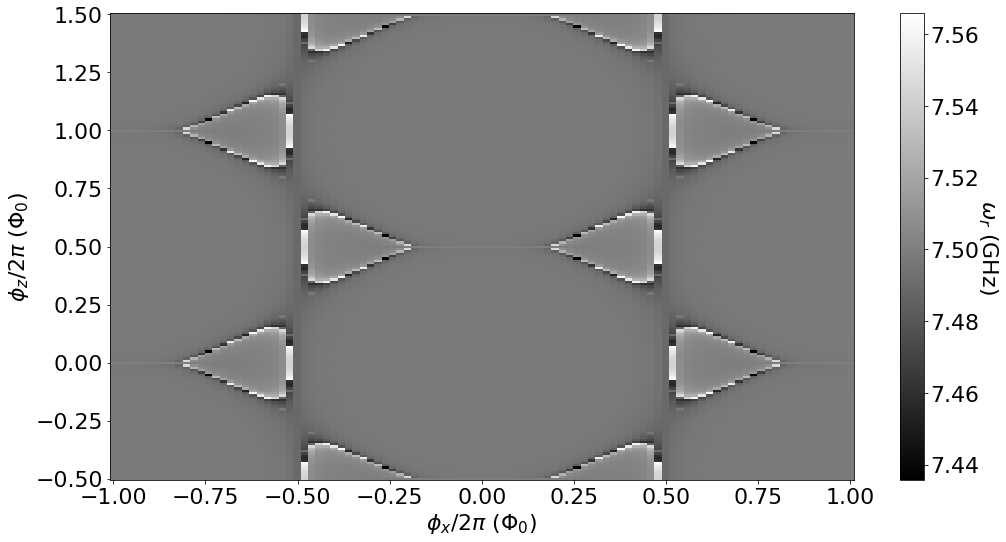

In [12]:
# Plot map
plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",S1,"$\\omega_r$ (GHz)")

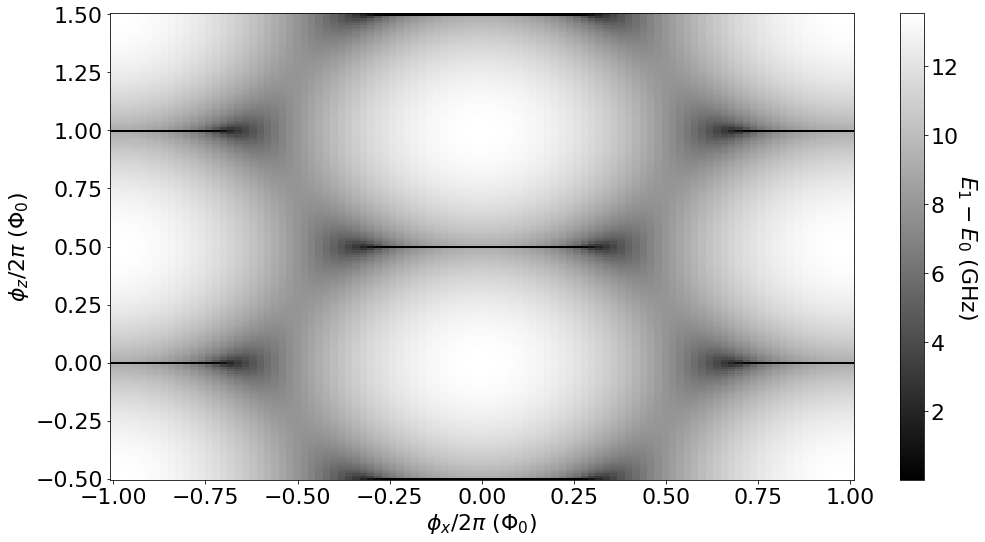

In [13]:
# Plot map
plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",Z1,"$E_1 - E_0$ (GHz)")

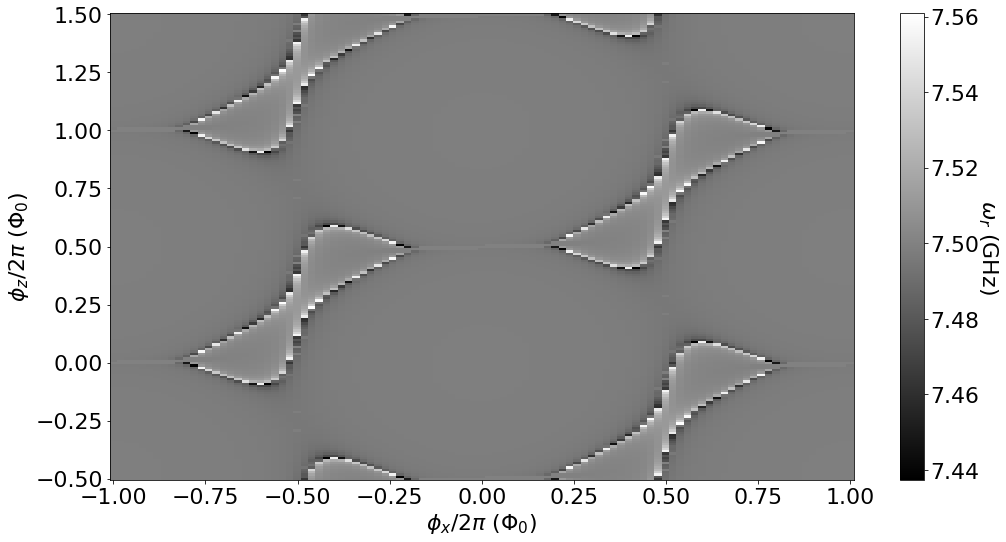

In [14]:
# Plot map
plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",S2,"$\\omega_r$ (GHz)")

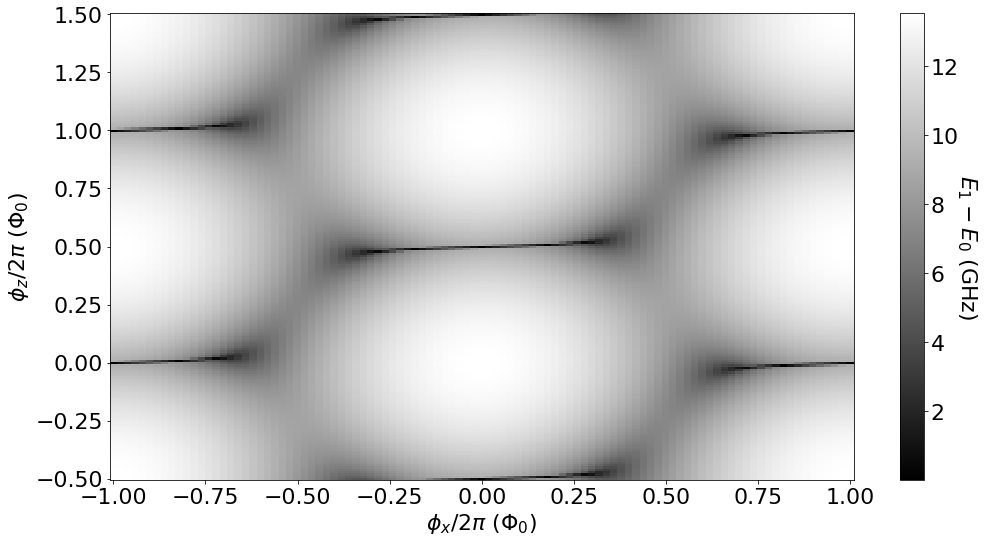

In [15]:
# Plot map
plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",Z2,"$E_1 - E_0$ (GHz)")

## Data Fitting Procedure

We would like to be able to use the resonator flux modulation data taken on a grid of flux parameters $\phi_x$ and $\phi_z$ to determine the system parameters, notably the resonator coupling constant $g_0$ and other parameters not easily determined through modelling, such as the stray capacitance contributions to the qubit shunting capacitor.

Using a VNA to probe the feed-line coupled resonator transmission coefficient over a range of frequencies provides a way to directly measure the shift in the resonance as a function of the flux parameters. Using both the magnitude and phase of the transmission coefficient provides an accurate estimation of the resonance as a function of the flux parameters.

Since non-linear fitting of the data to a realistic model of the qubit-resonator system is time-consuming, we need to find a series of points in the flux parameter space at which the resonator shift is most sensitive to a change in the parameters we would like to fit. To do this, we want to find points in the flux space such that

$$\left\{ \phi_{x,i}, \phi_{z,i} \right\} = \underset {\left\{ \phi_x, \phi_z \right\}}{\operatorname {arg\,max}} \left| \frac{\partial \omega_\mathrm{r,eff}}{\partial p_i} \left(\phi_x, \phi_z\right) \right| $$

where $p_i$ is some parameter of interest in the system and $\left\{ \phi_{x,i}, \phi_{z,i} \right\}$ is a set of coordinates in flux space that satisfy the condition.

As a first test, we can take a series of low-density maps of the effective resonator frequency as a function of the coupling $g_0$ so that we can estimate the rate of change of any point in the map with respect to this parameter.

In [7]:
import JC

# Coupling constants
gvals = np.logspace(1,3,11)*0.0001

# 2D param sweep
phix = np.linspace(-2*np.pi,2*np.pi,21)
phiz = np.linspace(-2*np.pi,2*np.pi,21)

# Qubit def
qubit1_params = {"Ajj":0.31*0.2,"alpha":0.97,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

# Resonator params
nmax = 5
omega_r = 7.5

# Progress
f = FloatProgress(min=0, max=(len(phix)*len(phiz)*len(gvals)))
print("XZ sweep progress:")
display(f)

# Loop over coupling constant
g0_SZ = []
for g0 in gvals:
    print ("Doing g0 = %f." % g0)

    # Do the sweep
    Z = np.zeros([len(phix),len(phiz)])
    S = np.zeros([len(phix),len(phiz)])
    i = 0
    j = 0
    for x in phix:
        j = 0
        for z in phiz:
            Ei,psii = qubit1.op_hamiltonian(x,z,ret=True).eigenstates()
            Z[i,j] = Ei[1]-Ei[0]

            # Get RWA coupling terms for JC
            g_list = []
            for k in range(len(Ei)-1):
                g = (psii[k].dag()*qubit1.op_charge_number()*psii[k+1])[0][0][0]
                g_list.append(np.abs(g))

            # Diagonalise RWA strip
            Erwa, psirwa = JC.diagonalize_ladder(nmax, omega_r, Ei-Ei[0], g0*np.array(g_list))
            response = JC.get_res_response(Erwa)
            S[i,j] = response[0][0]
            f.value += 1
            j+=1
        i+=1    
    g0_SZ.append((Z,S))

# Save this sweep for later use
saveBin(g0_SZ,"g0_SZ.bin")

[Ajj] = 6.200000e-02
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.254684e-13 F
[Ec] = 3.436442e-01 GHz
[Ej (large)] = 9.238313e+01 GHz
[Ej (small)] = 8.961164e+01 GHz
[Ej/Ec] = 260.8

XZ sweep progress:


FloatProgress(value=0.0, max=4851.0)

Doing g0 = 0.001000.
Doing g0 = 0.001585.
Doing g0 = 0.002512.
Doing g0 = 0.003981.
Doing g0 = 0.006310.
Doing g0 = 0.010000.
Doing g0 = 0.015849.
Doing g0 = 0.025119.
Doing g0 = 0.039811.
Doing g0 = 0.063096.
Doing g0 = 0.100000.


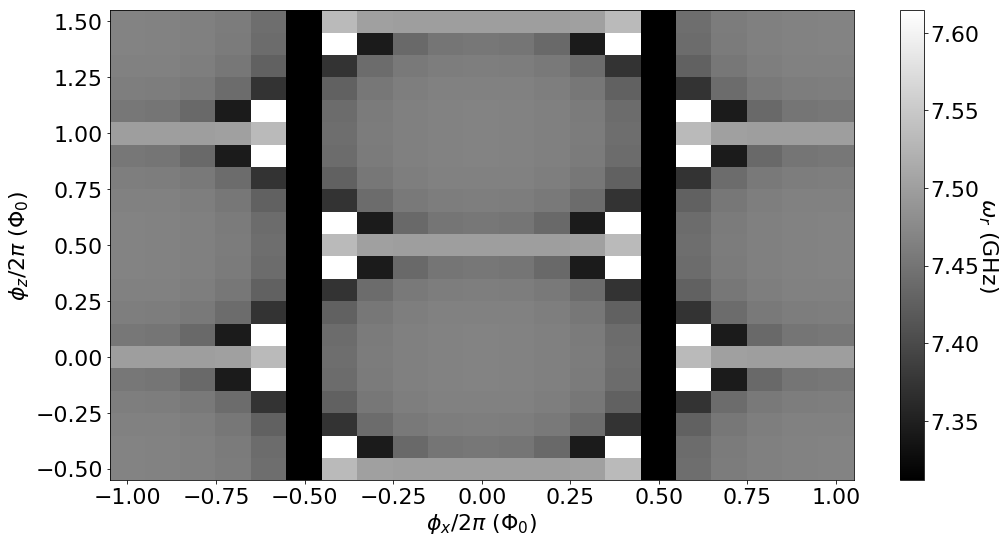

In [32]:
# Plot map
# 2D param sweep
phix = np.linspace(-2*np.pi,2*np.pi,21)
phiz = np.linspace(-2*np.pi,2*np.pi,21)
plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",g0_SZ[-1][1].T,"$\\omega_r$ (GHz)")

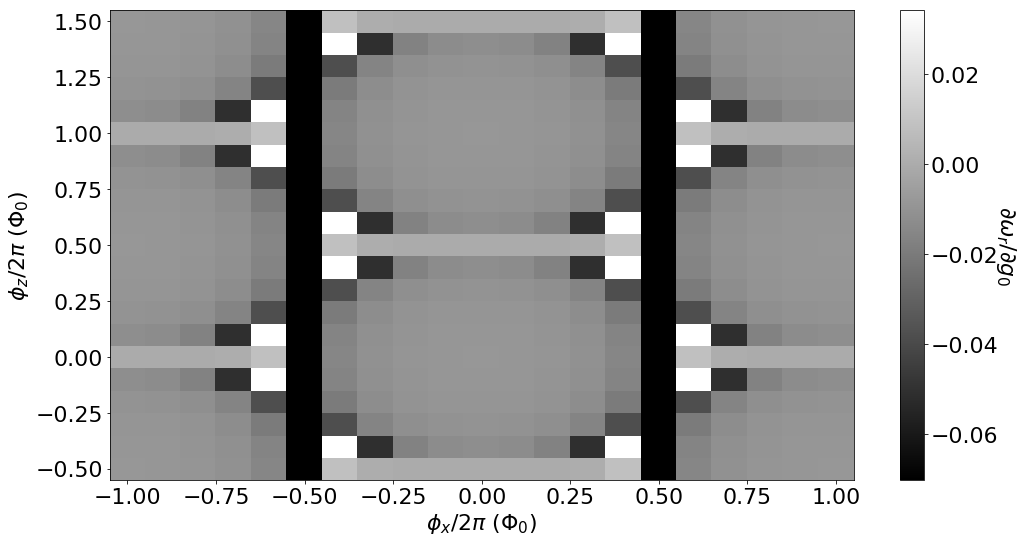

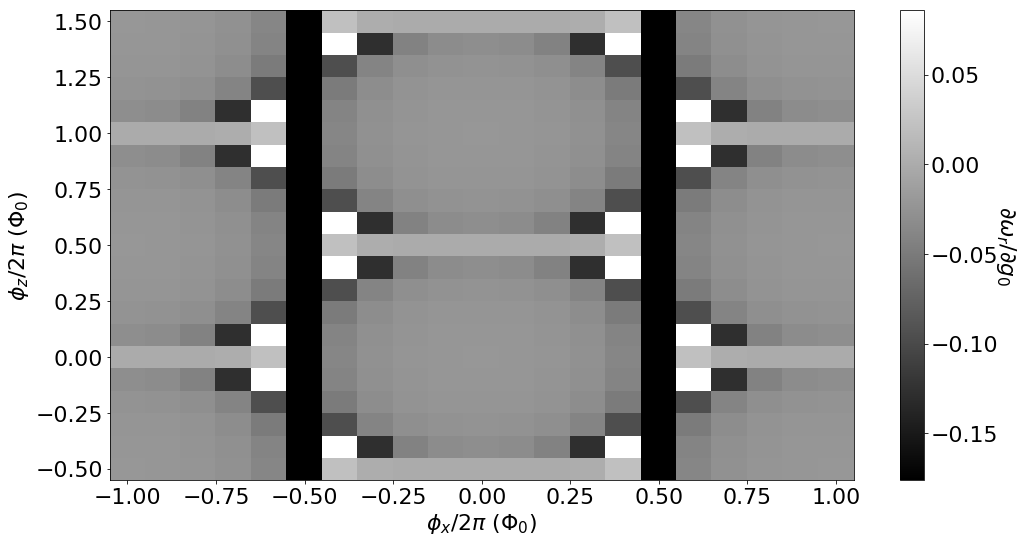

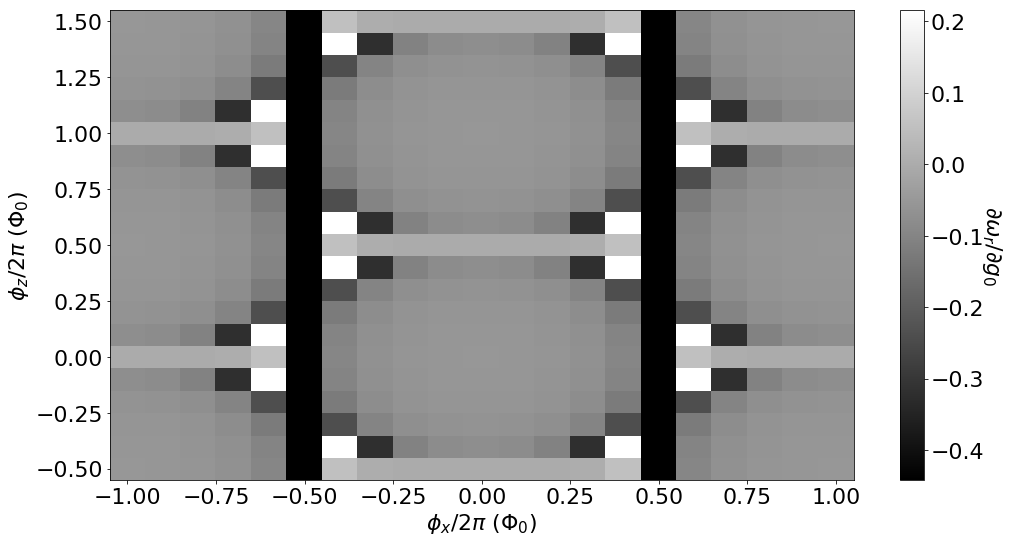

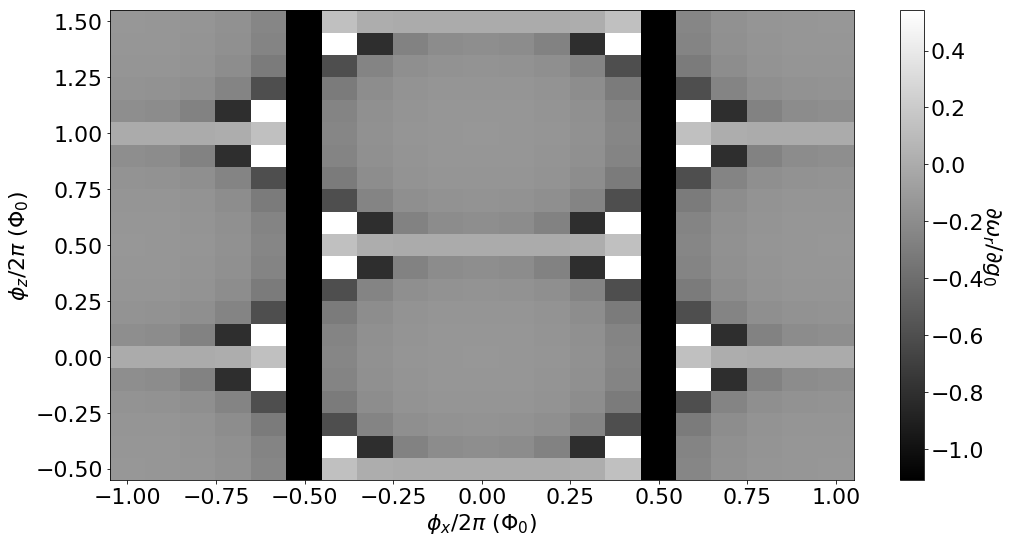

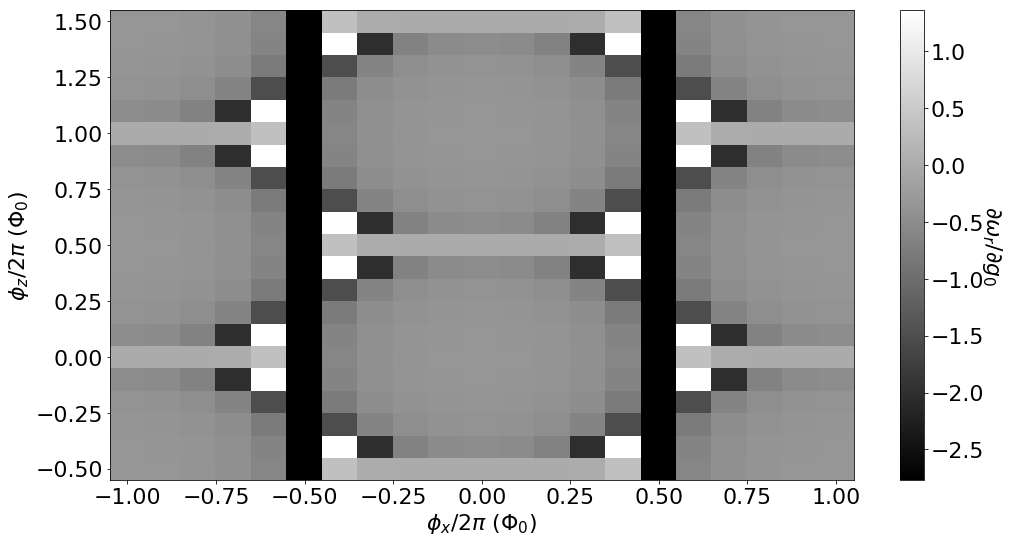

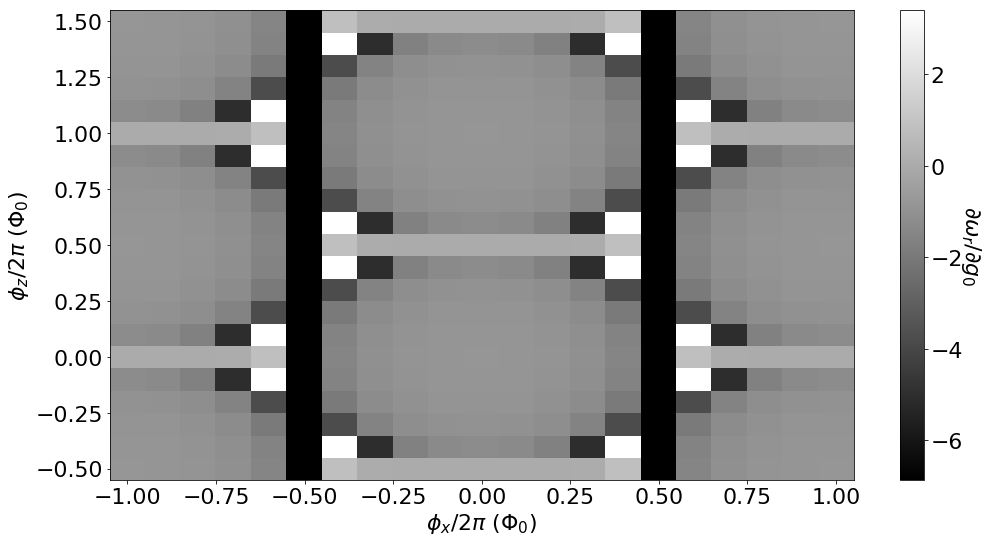

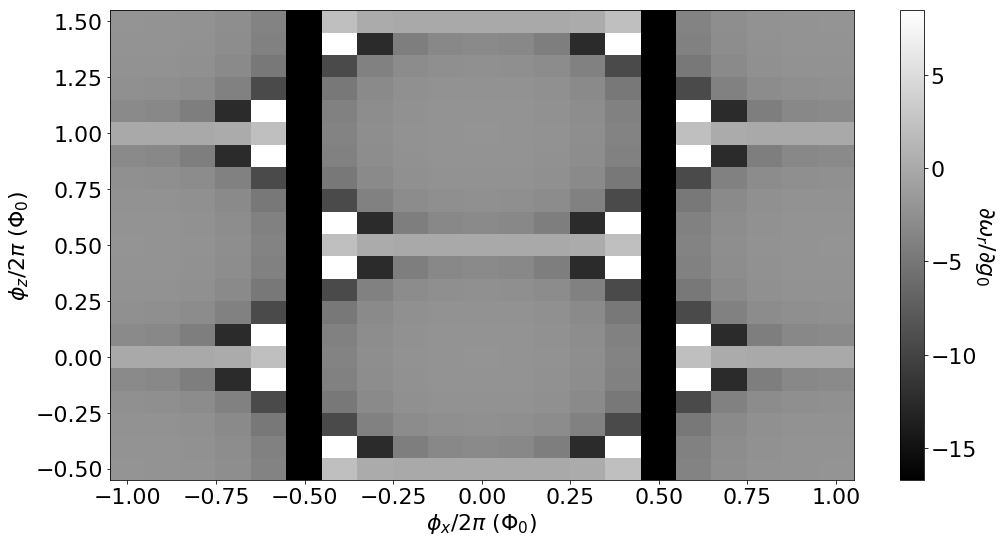

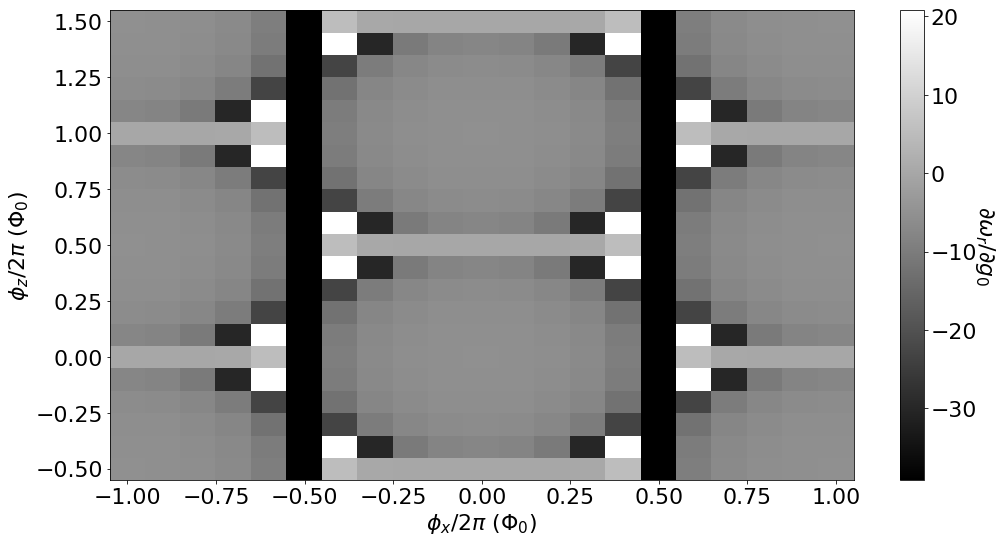

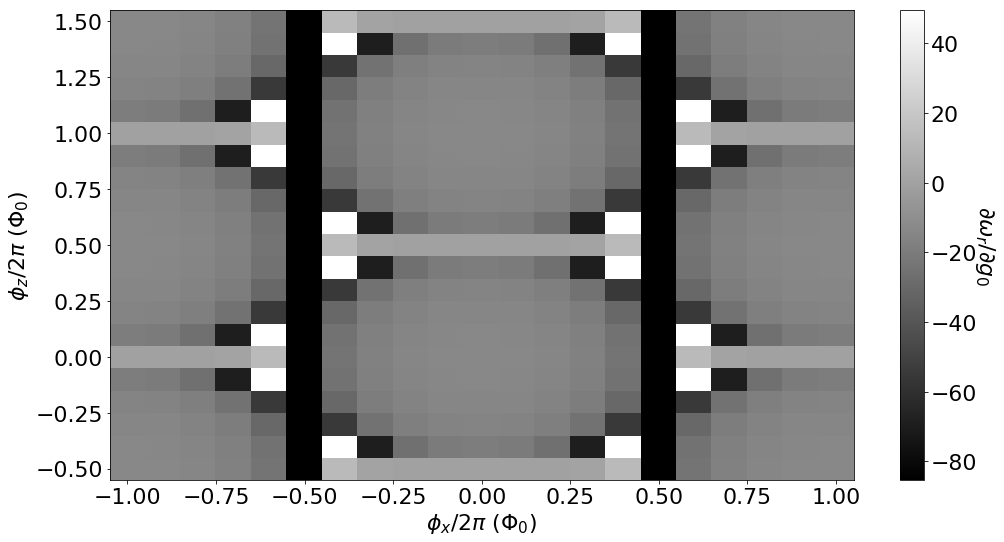

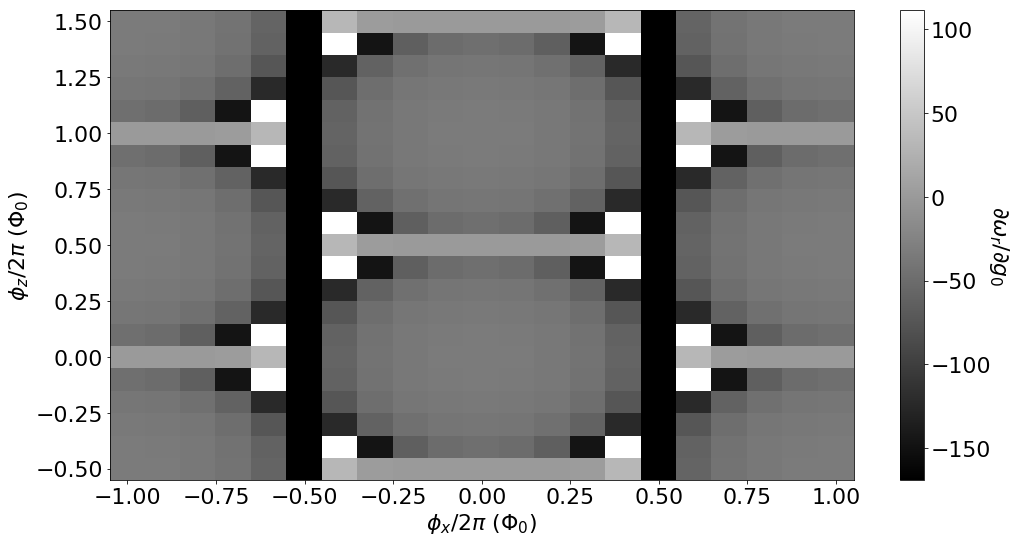

In [33]:
# Take the numerical derivative at each point and plot them
dSdg_list = []
for i in range(len(gvals)-1):
    S0 = g0_SZ[i][1]
    S1 = g0_SZ[i+1][1]
    dSdg = (S1-S0)/(gvals[1]-gvals[0])
    dSdg_list.append(dSdg)
    plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",dSdg.T,"$\\partial\\omega_r / \\partial g_0$")


In [34]:
# Find the points with the highest derivatives
index = -1
d = np.abs(dSdg_list[index])
xpts = []
ypts = []
coords_list = []
for i in range(58):
    coords = np.unravel_index(d.argmax(),d.shape)
    d[coords[0],coords[1]] = -1
    print ("Found %e at (%i,%i)" % (dSdg_list[index][coords[0],coords[1]],coords[0],coords[1]))
    xpts.append(phix[coords[0]]/(2*np.pi))
    ypts.append(phiz[coords[1]]/(2*np.pi) + 0.5)
    coords_list.append(coords)

Found -1.689324e+02 at (5,0)
Found -1.689324e+02 at (5,1)
Found -1.689324e+02 at (5,2)
Found -1.689324e+02 at (5,3)
Found -1.689324e+02 at (5,4)
Found -1.689324e+02 at (5,5)
Found -1.689324e+02 at (5,6)
Found -1.689324e+02 at (5,7)
Found -1.689324e+02 at (5,8)
Found -1.689324e+02 at (5,9)
Found -1.689324e+02 at (5,10)
Found -1.689324e+02 at (5,11)
Found -1.689324e+02 at (5,12)
Found -1.689324e+02 at (5,13)
Found -1.689324e+02 at (5,14)
Found -1.689324e+02 at (5,15)
Found -1.689324e+02 at (5,16)
Found -1.689324e+02 at (5,17)
Found -1.689324e+02 at (5,18)
Found -1.689324e+02 at (5,19)
Found -1.689324e+02 at (5,20)
Found -1.689324e+02 at (15,0)
Found -1.689324e+02 at (15,1)
Found -1.689324e+02 at (15,2)
Found -1.689324e+02 at (15,3)
Found -1.689324e+02 at (15,4)
Found -1.689324e+02 at (15,5)
Found -1.689324e+02 at (15,6)
Found -1.689324e+02 at (15,7)
Found -1.689324e+02 at (15,8)
Found -1.689324e+02 at (15,9)
Found -1.689324e+02 at (15,10)
Found -1.689324e+02 at (15,11)
Found -1.689324e+0

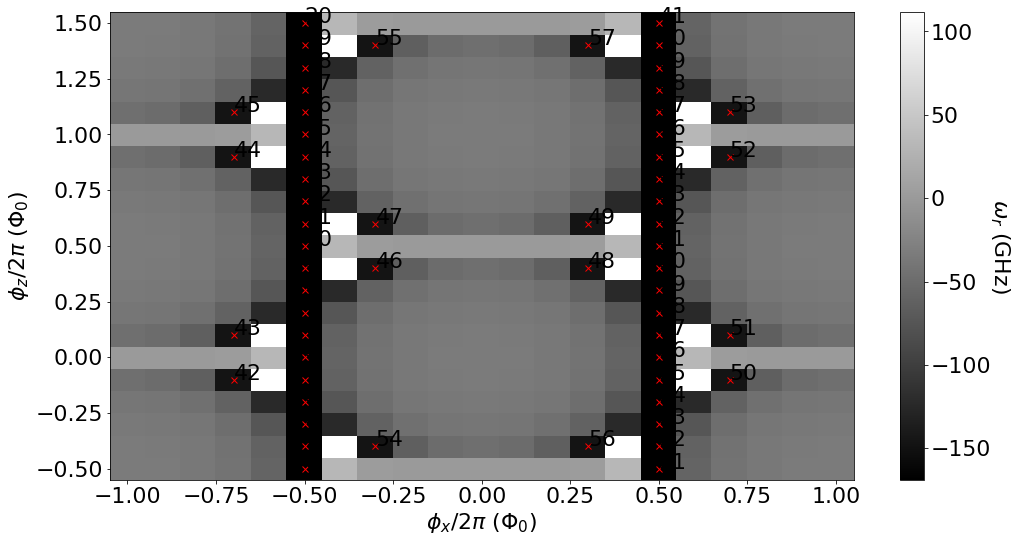

In [35]:
# Plot the points
plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",dSdg_list[index].T,"$\\omega_r$ (GHz)",markers=(xpts,ypts,"rx"))

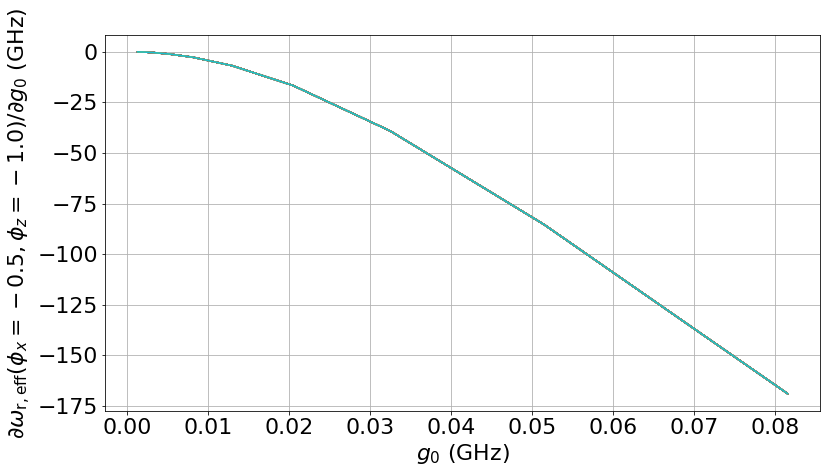

In [38]:
# Plot the same maxima points from each value of g
dSdg_samples = []
for j in range(10):
    dSdg_sample = []
    for i in range(len(dSdg_list)):
        dSdg_sample.append(dSdg_list[i][coords_list[j][0],coords_list[j][1]])
    dSdg_samples.append(dSdg_sample)

gvals_mod = [gvals[i]+(gvals[i+1]-gvals[i])/2 for i in range(len(gvals)-1)]

fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
for dSdg_sample in dSdg_samples:
    ax1.plot(gvals_mod, dSdg_sample)
#ax1.plot(gvals_mod, dSdg_sample,"kx")
#ax1.plot(gvals, np.zeros(len(gvals)), "ko")
ax1.set_xlabel('$g_0$ (GHz)')
ax1.set_ylabel('$\\partial \\omega_\\mathrm{r,eff} \\left( \\phi_x = %.1f, \\phi_z = %.1f \\right) / \\partial g_0$ (GHz)' % (phix[coords_list[0][0]]/(2*np.pi),phiz[coords_list[0][1]]/(2*np.pi)))
ax1.grid()
fig.tight_layout()

We can do the same for the asymmetry parameter $d$:

In [8]:
import JC

# Asymmetry param sweep
dvals = np.linspace(0.01,0.2,11)

# 2D param sweep
phix = np.linspace(-2*np.pi,2*np.pi,41)
phiz = np.linspace(-2*np.pi,2*np.pi,41)

# Resonator params
nmax = 5
omega_r = 7.5

# Coupling params
g0 = 0.02

# Progress
f = FloatProgress(min=0, max=(len(phix)*len(phiz)*len(dvals)))
print("XZ sweep progress:")
display(f)

# Loop over coupling constant
d_SZ = []
for d in dvals:
    print ("Doing d = %f." % d)
    
    # Qubit def
    qubit1_params = {"Ajj":0.31*0.2,"alpha":0.97,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80,"Xasy":d}
    qubit1 = CSFQ_Qubit(qubit1_params)
    qubit1.info()

    # Do the sweep
    Z = np.zeros([len(phix),len(phiz)])
    S = np.zeros([len(phix),len(phiz)])
    i = 0
    j = 0
    for x in phix:
        j = 0
        for z in phiz:
            Ei,psii = qubit1.op_hamiltonian_asy(x,z,ret=True).eigenstates()
            Z[i,j] = Ei[1]-Ei[0]

            # Get RWA coupling terms for JC
            g_list = []
            for k in range(len(Ei)-1):
                g = (psii[k].dag()*qubit1.op_charge_number()*psii[k+1])[0][0][0]
                g_list.append(np.abs(g))

            # Diagonalise RWA strip
            Erwa, psirwa = JC.diagonalize_ladder(nmax, omega_r, Ei-Ei[0], g0*np.array(g_list))
            response = JC.get_res_response(Erwa)
            S[i,j] = response[0][0]
            f.value += 1
            j+=1
        i+=1    
    d_SZ.append((Z,S))

# Save this sweep for later use
saveBin(d_SZ,"d_SZ.bin")

XZ sweep progress:


FloatProgress(value=0.0, max=18491.0)

Doing d = 0.010000.
[Ajj] = 6.200000e-02
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Xasy] = 1.000000e-02
[Csigma] = 2.254684e-13 F
[Ec] = 3.436442e-01 GHz
[Ej (large)] = 9.238313e+01 GHz
[Ej (small)] = 8.961164e+01 GHz
[Ej/Ec] = 260.8

Doing d = 0.029000.
[Ajj] = 6.200000e-02
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Xasy] = 2.900000e-02
[Csigma] = 2.254684e-13 F
[Ec] = 3.436442e-01 GHz
[Ej (large)] = 9.238313e+01 GHz
[Ej (small)] = 8.961164e+01 GHz
[Ej/Ec] = 260.8

Doing d = 0.048000.
[Ajj] = 6.200000e-02
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Xasy] = 4.800000e-02
[Csigma] = 2.254684e-13 F
[Ec] = 3.436442e-01 GHz
[Ej (large)] = 9.238313e+01 GHz
[Ej (small)] = 8.961164e+01 GHz
[Ej/Ec] = 260.8

Doing d = 0.067000.
[Ajj] = 6.200000e-02
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.0000

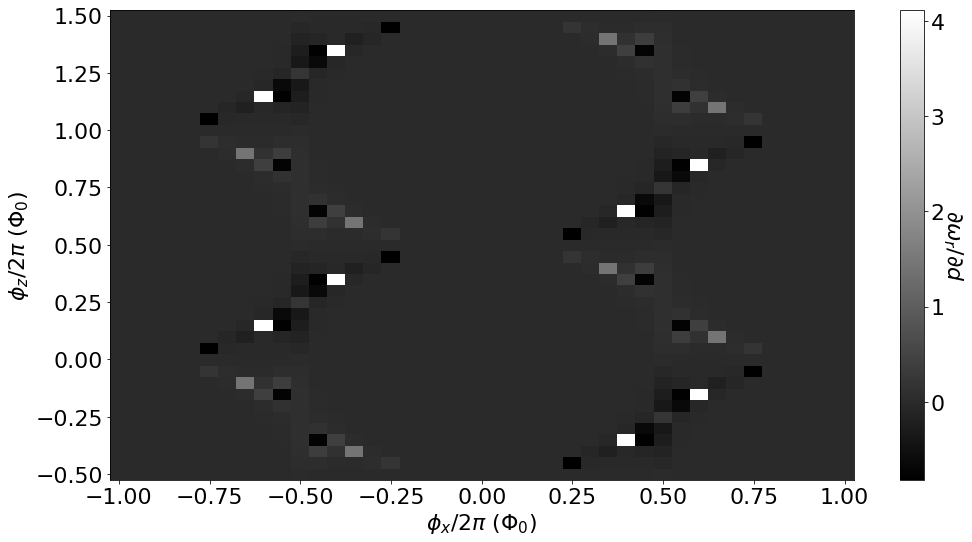

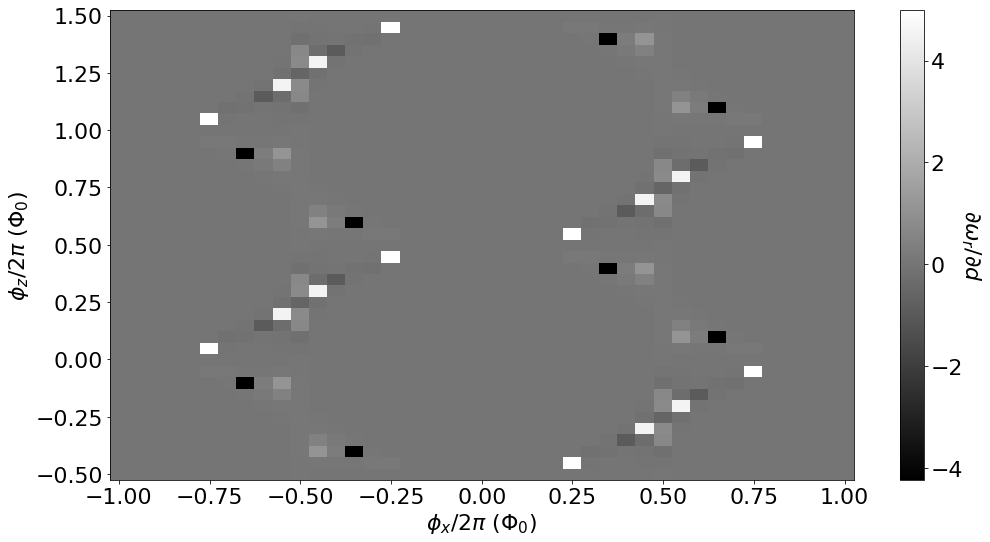

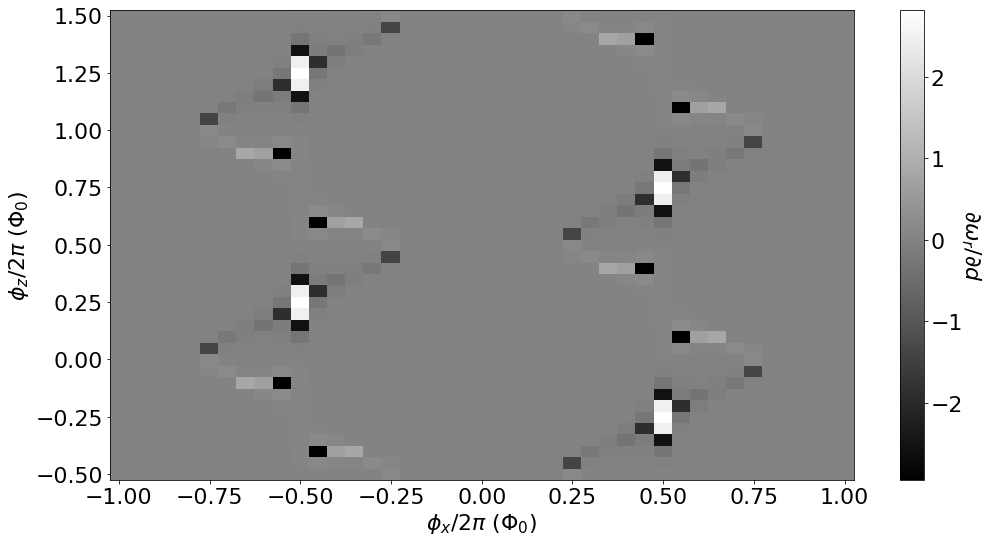

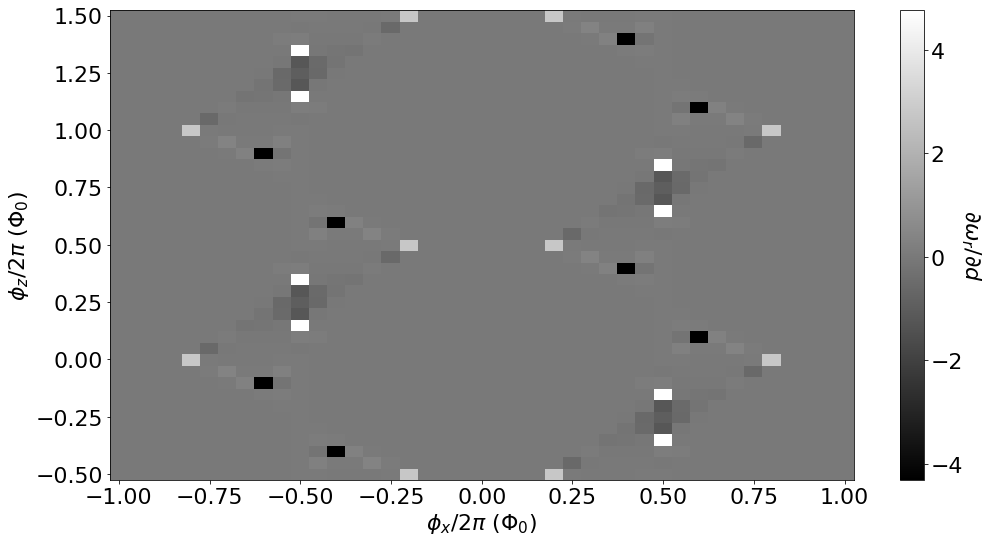

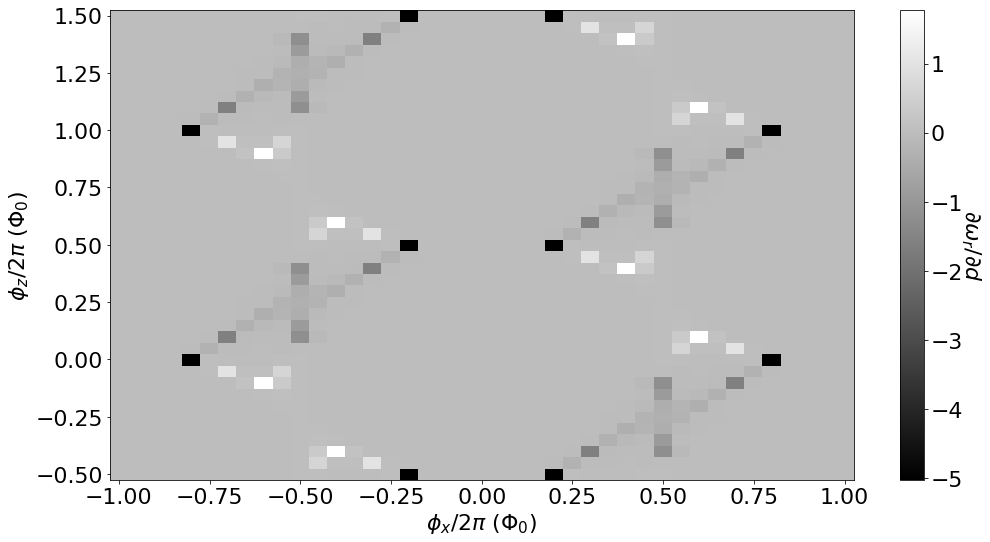

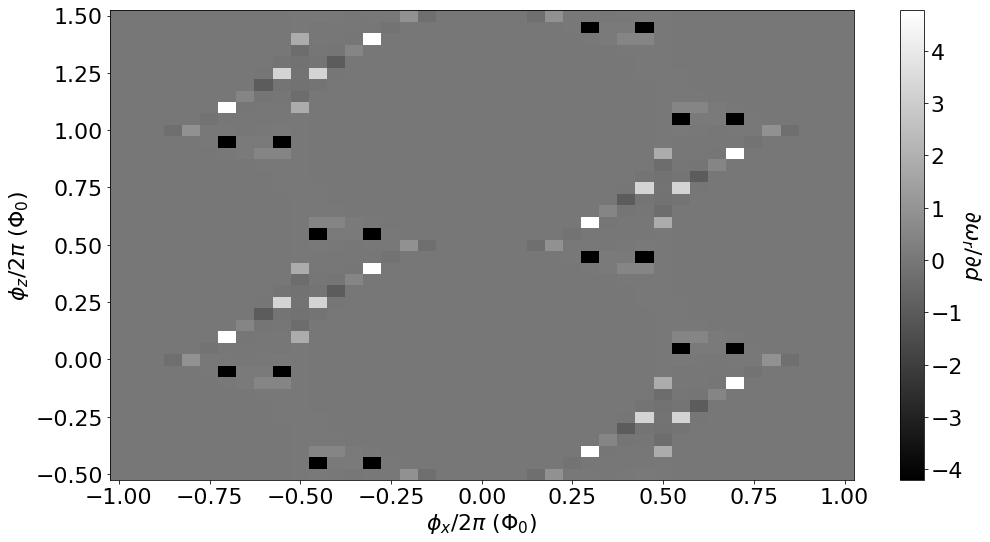

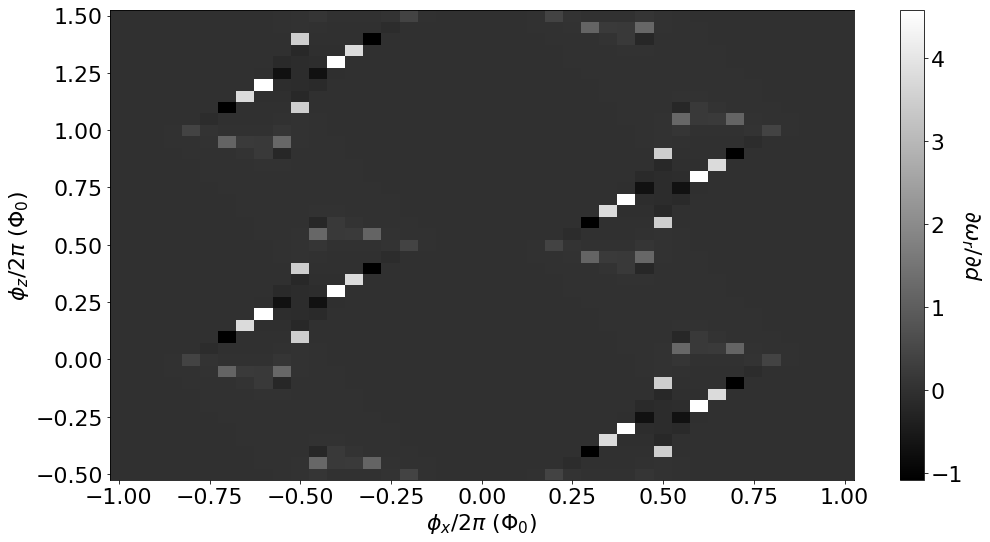

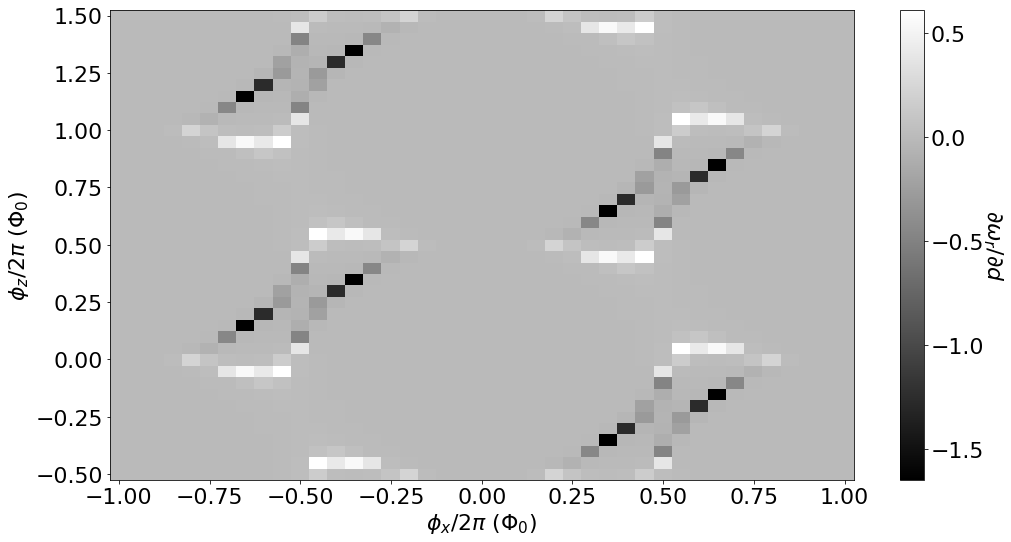

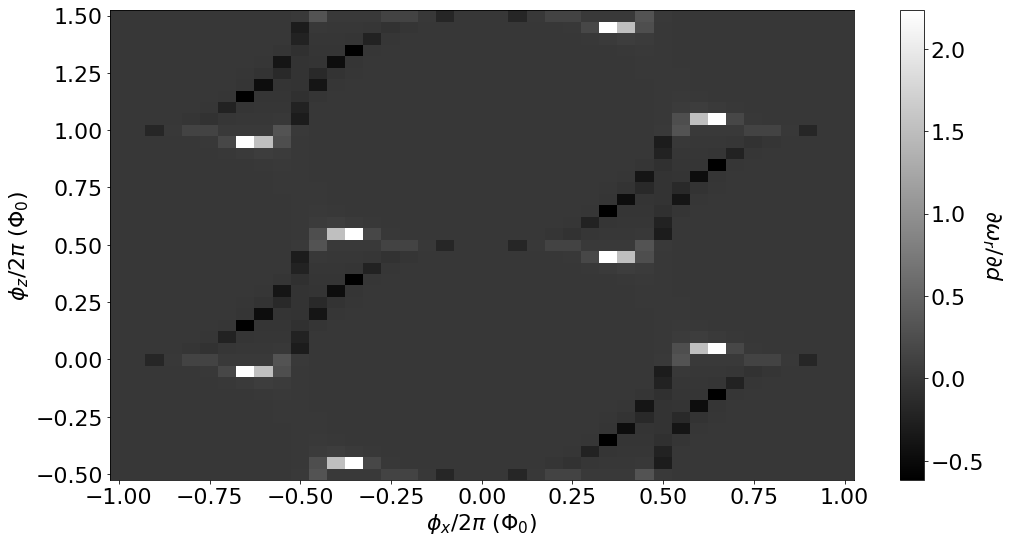

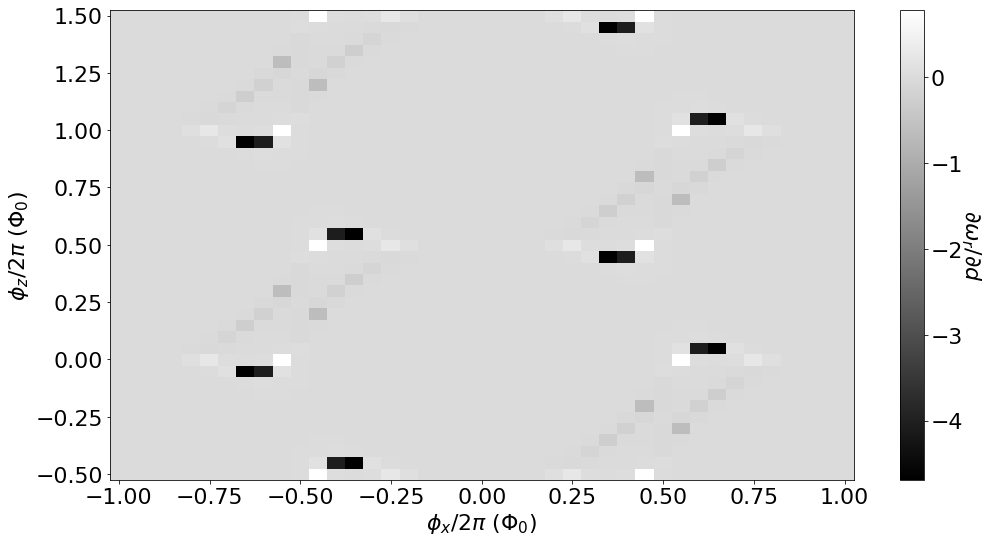

In [41]:
# 2D param sweep
phix = np.linspace(-2*np.pi,2*np.pi,41)
phiz = np.linspace(-2*np.pi,2*np.pi,41)
# Take the numerical derivative at each point and plot them
dSdd_list = []
for i in range(len(dvals)-1):
    S0 = d_SZ[i][1]
    S1 = d_SZ[i+1][1]
    dSdd = (S1-S0)/(dvals[1]-dvals[0])
    dSdd_list.append(dSdd)
    plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",dSdd.T,"$\\partial\\omega_r / \\partial d$")


In [42]:
# Find the points with the highest derivatives
index = 0
ds = np.abs(dSdd_list[index])
xpts = []
ypts = []
coords_list = []
for i in range(58):
    coords = np.unravel_index(ds.argmax(),ds.shape)
    ds[coords[0],coords[1]] = -1
    print ("Found %e at (%i,%i)" % (dSdd_list[index][coords[0],coords[1]],coords[0],coords[1]))
    xpts.append(phix[coords[0]]/(2*np.pi))
    ypts.append(phiz[coords[1]]/(2*np.pi) + 0.5)
    coords_list.append(coords)

Found 4.120544e+00 at (12,37)
Found 4.120544e+00 at (28,3)
Found 4.120544e+00 at (12,17)
Found 4.120544e+00 at (28,23)
Found 4.120544e+00 at (8,13)
Found 4.120544e+00 at (32,27)
Found 4.120544e+00 at (8,33)
Found 4.120544e+00 at (32,7)
Found 1.430876e+00 at (7,28)
Found 1.430876e+00 at (13,2)
Found 1.430876e+00 at (13,22)
Found 1.430876e+00 at (27,18)
Found 1.430876e+00 at (27,38)
Found 1.430876e+00 at (33,12)
Found 1.430876e+00 at (7,8)
Found 1.430876e+00 at (33,32)
Found -8.212189e-01 at (15,19)
Found -8.212189e-01 at (25,21)
Found -8.212189e-01 at (5,11)
Found -8.212189e-01 at (5,31)
Found -8.212189e-01 at (15,39)
Found -8.212189e-01 at (25,1)
Found -8.212189e-01 at (35,9)
Found -8.212189e-01 at (35,29)
Found -7.829011e-01 at (11,37)
Found -7.829011e-01 at (29,3)
Found -7.829011e-01 at (9,13)
Found -7.829011e-01 at (31,27)
Found -7.829011e-01 at (11,17)
Found -7.829011e-01 at (29,23)
Found -7.829011e-01 at (9,33)
Found -7.829011e-01 at (31,7)
Found -7.582729e-01 at (11,23)
Found -7.

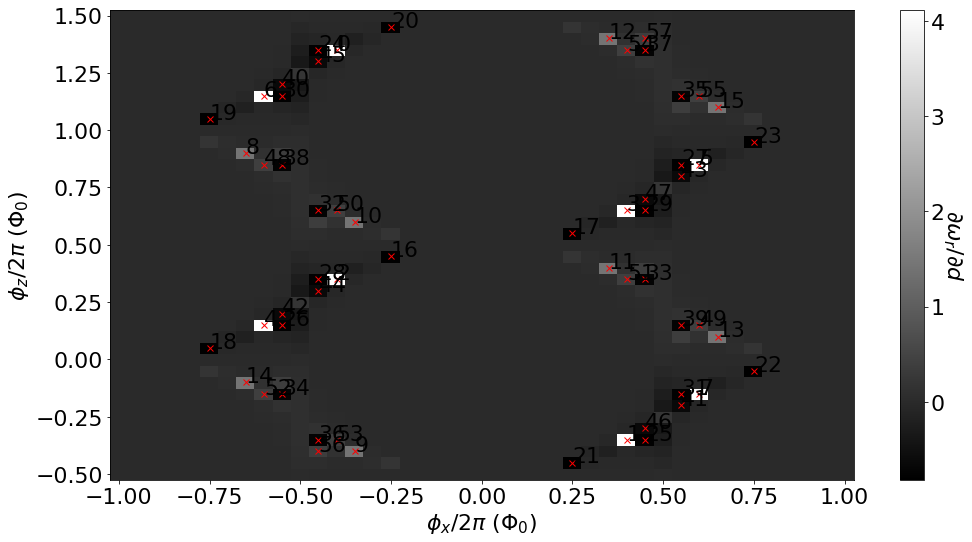

In [46]:
# Plot the points
plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",dSdd_list[index].T,"$\\partial \\omega_r / \\partial d$",markers=(xpts,ypts,"rx"))

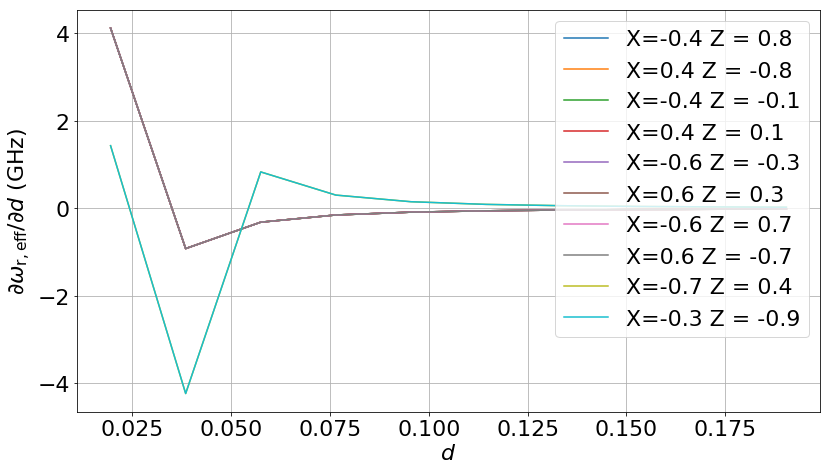

In [45]:
# Plot the same maxima points from each value of d
dSdd_samples = []
for j in range(10):
    dSdd_sample = []
    for i in range(len(dSdd_list)):
        dSdd_sample.append(dSdd_list[i][coords_list[j][0],coords_list[j][1]])
    dSdd_samples.append(dSdd_sample)

dvals_mod = [dvals[i]+(dvals[i+1]-dvals[i])/2 for i in range(len(dvals)-1)]

fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
j = 0
for dSdd_sample in dSdd_samples:
    ax1.plot(dvals_mod, dSdd_sample,label="X=%.1f Z = %.1f"%(phix[coords_list[j][0]]/(2*np.pi),phiz[coords_list[j][1]]/(2*np.pi)))
    j+=1
#ax1.plot(dvals_mod, dSdd_sample,"kx")
#ax1.plot(dvals, np.zeros(len(dvals)), "ko")
ax1.set_xlabel('$d$')
ax1.set_ylabel('$\\partial \\omega_\\mathrm{r,eff} / \\partial d$ (GHz)')
ax1.grid()
ax1.legend(loc=1)
fig.tight_layout()

Now for the photon number $n$:

In [44]:
import JC

# 2D param sweep
phix = np.linspace(-2*np.pi,2*np.pi,21)
phiz = np.linspace(-2*np.pi,2*np.pi,21)

# Resonator params
nmax = 100
omega_r = 7.5

# Coupling params
g0 = 0.02

# Progress
f = FloatProgress(min=0, max=(len(phix)*len(phiz)))
print("XZ sweep progress:")
display(f)

# Loop over coupling constant
n_SZ = []

# Qubit def
qubit1_params = {"Ajj":0.31*0.2,"alpha":0.97,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

# Do the sweep
Z = np.zeros([len(phix),len(phiz)])
S = np.zeros([nmax,len(phix),len(phiz)])
i = 0
j = 0
for x in phix:
    j = 0
    for z in phiz:
        Ei,psii = qubit1.op_hamiltonian(x,z,ret=True).eigenstates()
        Z[i,j] = Ei[1]-Ei[0]

        # Get RWA coupling terms for JC
        g_list = []
        for k in range(len(Ei)-1):
            g = (psii[k].dag()*qubit1.op_charge_number()*psii[k+1])[0][0][0]
            g_list.append(np.abs(g))

        # Diagonalise RWA strip
        Erwa, psirwa = JC.diagonalize_ladder(nmax, omega_r, Ei-Ei[0], g0*np.array(g_list))
        response = JC.get_res_response(Erwa)
        for k in range(nmax-1):
            S[k,i,j] = response[0][k]
        f.value += 1
        j+=1
    i+=1

# Save this sweep for later use
saveBin(S,"n_SZ.bin")

XZ sweep progress:


FloatProgress(value=0.0, max=441.0)

[Ajj] = 6.200000e-02
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.254684e-13 F
[Ec] = 3.436442e-01 GHz
[Ej (large)] = 9.238313e+01 GHz
[Ej (small)] = 8.961164e+01 GHz
[Ej/Ec] = 260.8



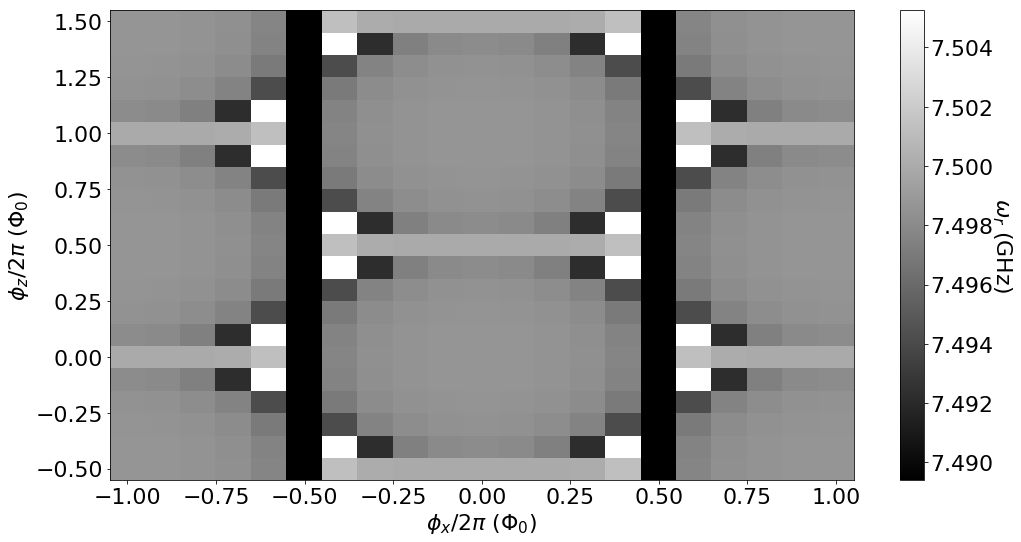

In [48]:
plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",S[0].T,"$\\omega_r$ (GHz)")

In [50]:
# Take the numerical derivative at each point and plot them
dSdn_list = []
for i in range(nmax-2):
    S0 = S[i]
    S1 = S[i+1]
    dSdn = (S1-S0)
    dSdn_list.append(dSdn)
    #plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",dSdd.T,"$\\partial\\omega_r / \\partial d$")

In [54]:
# Find the points with the highest derivatives
index = 30
ns = np.abs(dSdn_list[index])
xpts = []
ypts = []
coords_list = []
for i in range(58):
    coords = np.unravel_index(ns.argmax(),ns.shape)
    ns[coords[0],coords[1]] = -1
    print ("Found %e at (%i,%i)" % (dSdn_list[index][coords[0],coords[1]],coords[0],coords[1]))
    xpts.append(phix[coords[0]]/(2*np.pi))
    ypts.append(phiz[coords[1]]/(2*np.pi) + 0.5)
    coords_list.append(coords)

Found 6.175383e-05 at (7,9)
Found 6.175383e-05 at (7,11)
Found 6.175383e-05 at (13,9)
Found 6.175383e-05 at (13,11)
Found 6.175383e-05 at (3,4)
Found 6.175383e-05 at (3,6)
Found 6.175383e-05 at (3,14)
Found 6.175383e-05 at (3,16)
Found 6.175383e-05 at (17,4)
Found 6.175383e-05 at (17,6)
Found 6.175383e-05 at (17,14)
Found 6.175383e-05 at (17,16)
Found 6.175383e-05 at (7,1)
Found 6.175383e-05 at (7,19)
Found 6.175383e-05 at (13,1)
Found 6.175383e-05 at (13,19)
Found -4.120887e-05 at (5,0)
Found -4.120887e-05 at (5,1)
Found -4.120887e-05 at (5,2)
Found -4.120887e-05 at (5,3)
Found -4.120887e-05 at (5,4)
Found -4.120887e-05 at (5,5)
Found -4.120887e-05 at (5,6)
Found -4.120887e-05 at (5,7)
Found -4.120887e-05 at (5,8)
Found -4.120887e-05 at (5,9)
Found -4.120887e-05 at (5,10)
Found -4.120887e-05 at (5,11)
Found -4.120887e-05 at (5,12)
Found -4.120887e-05 at (5,13)
Found -4.120887e-05 at (5,14)
Found -4.120887e-05 at (5,15)
Found -4.120887e-05 at (5,16)
Found -4.120887e-05 at (5,17)
Found 

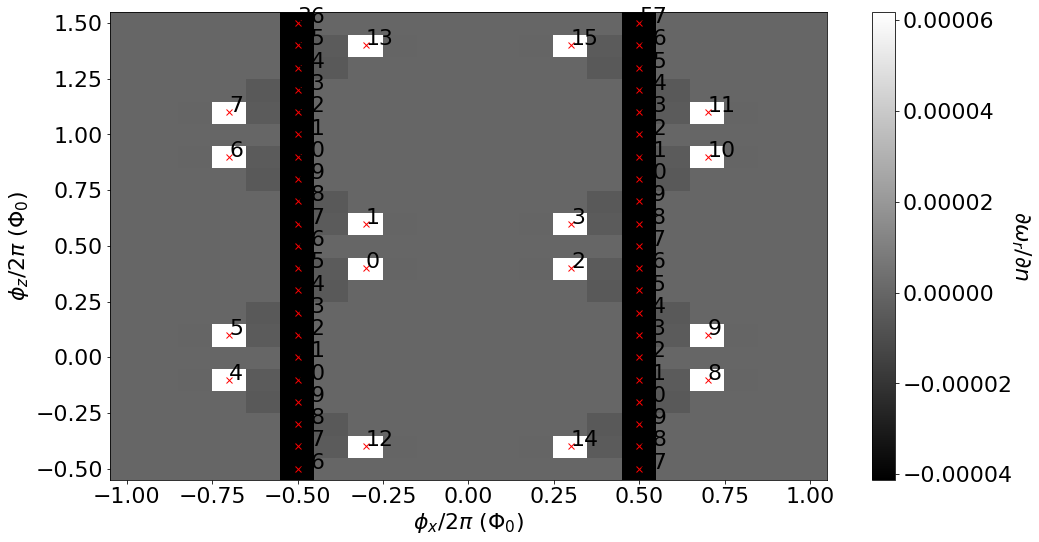

In [55]:
# Plot the points
plot_map(phix/(2*np.pi),"$\\phi_x/2\\pi$ ($\\Phi_0$)",phiz/(2*np.pi)+0.5,"$\\phi_z/2\\pi$ ($\\Phi_0$)",dSdn_list[index].T,"$\\partial \\omega_r / \\partial n$",markers=(xpts,ypts,"rx"))

In [39]:
import JC
phiz = np.linspace(-4*np.pi,4*np.pi,601)

# Qubit def
qubit1_params = {"Ajj":0.31*0.2,"alpha":0.97,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

# Resonator params
nmax = 50
omega_r = 7.5
g0 = 0.02

# Resonator modulation against Z
# Progress
f = FloatProgress(min=0, max=(len(phiz)))
print("Z JC sweep progress:")
display(f)

# Do the sweep
x = 0.45*2*np.pi
g_list = []
omega_eff1 = []
omega_eff10 = []
omega_eff20 = []
omega_eff30 = []
omega_eff40 = []
for z in phiz:
    Ei,psii = qubit1.op_hamiltonian(x,z,ret=True).eigenstates()
    
    # Get RWA coupling terms for JC
    g_list = []
    for i in range(len(Ei)-1):
        g = (psii[i].dag()*qubit1.op_charge_number()*psii[i+1])[0][0][0]
        g_list.append(np.abs(g))
    
    # Diagonalise RWA strip
    Erwa, psirwa = JC.diagonalize_ladder(nmax, omega_r, Ei-Ei[0], g0*np.array(g_list))
    response = JC.get_res_response(Erwa)
    omega_eff1.append(response[0][0])
    omega_eff10.append(response[0][9])
    omega_eff20.append(response[0][19])
    omega_eff30.append(response[0][29])
    omega_eff40.append(response[0][39])
    
    f.value += 1


[Ajj] = 6.200000e-02
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.254684e-13 F
[Ec] = 3.436442e-01 GHz
[Ej (large)] = 9.238313e+01 GHz
[Ej (small)] = 8.961164e+01 GHz
[Ej/Ec] = 260.8

Z JC sweep progress:


FloatProgress(value=0.0, max=601.0)

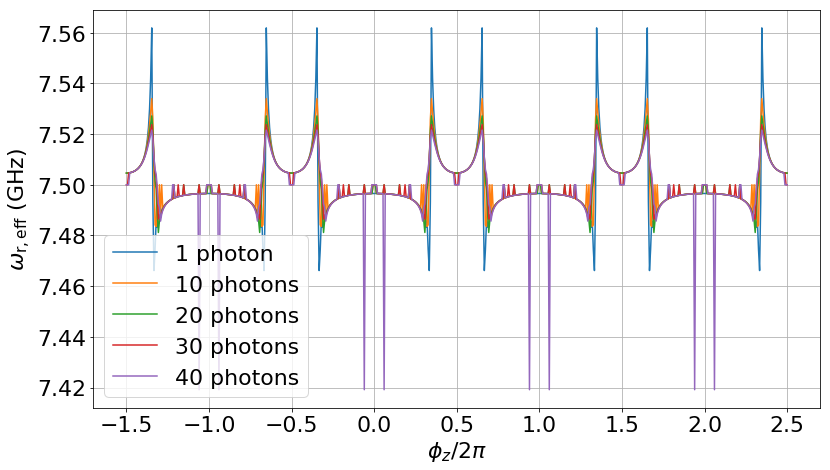

In [40]:
fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
ax1.plot(phiz/(2*np.pi)+0.5, omega_eff1,label="1 photon")
ax1.plot(phiz/(2*np.pi)+0.5, omega_eff10,label="10 photons")
ax1.plot(phiz/(2*np.pi)+0.5, omega_eff20,label="20 photons")
ax1.plot(phiz/(2*np.pi)+0.5, omega_eff30,label="30 photons")
ax1.plot(phiz/(2*np.pi)+0.5, omega_eff40,label="40 photons")
ax1.set_xlabel('$\\phi_z/2\\pi$')
ax1.set_ylabel('$\\omega_\\mathrm{r,eff}$ (GHz)')
ax1.grid()
ax1.legend()
#ax1.set_ylim([7.4,7.55])
fig.tight_layout()

In [11]:
import JC
phiz = np.linspace(-4*np.pi,4*np.pi,601)

# Qubit def
qubit1_params = {"Ajj":0.31*0.2,"alpha":0.97,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

# Resonator params
nmax = 5
omega_r = 7.5
g0 = 0.02

# Resonator modulation against Z
# Progress
f = FloatProgress(min=0, max=(len(phiz)))
print("Z JC sweep progress:")
display(f)

# Do the sweep
x = 0*2*np.pi
g_list = []
omega_eff2 = []
for z in phiz:
    Ei,psii = qubit1.op_hamiltonian(x,z,ret=True).eigenstates()
    
    # Get RWA coupling terms for JC
    g_list = []
    for i in range(len(Ei)-1):
        g = (psii[i].dag()*qubit1.op_charge_number()*psii[i+1])[0][0][0]
        g_list.append(np.abs(g))
    
    # Diagonalise RWA strip
    Erwa, psirwa = JC.diagonalize_ladder(nmax, omega_r, Ei[:3]-Ei[0], g0*np.array(g_list[:3]))
    response = JC.get_res_response(Erwa)
    omega_eff2.append(response[0][0])
    
    f.value += 1


[Ajj] = 6.200000e-02
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.254684e-13 F
[Ec] = 3.436442e-01 GHz
[Ej (large)] = 9.238313e+01 GHz
[Ej (small)] = 8.961164e+01 GHz
[Ej/Ec] = 260.8

Z JC sweep progress:


FloatProgress(value=0.0, max=601.0)

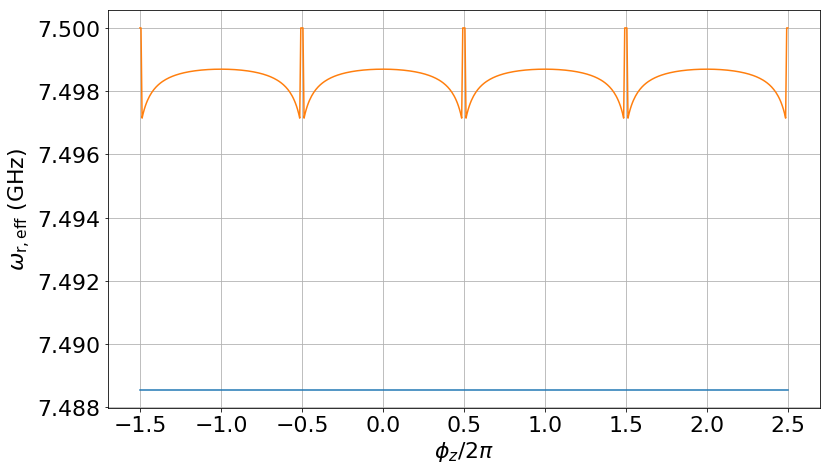

In [38]:
fig = plt.figure(figsize=(12,7))
ax1 = plt.subplot(111)
ax1.plot(phiz/(2*np.pi)+0.5, omega_eff30)
ax1.plot(phiz/(2*np.pi)+0.5, omega_eff2)
ax1.set_xlabel('$\\phi_z/2\\pi$')
ax1.set_ylabel('$\\omega_\\mathrm{r,eff}$ (GHz)')
ax1.grid()
#ax1.set_ylim([7.4,7.55])
fig.tight_layout()